In [1]:
%%capture
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
from tqdm import tqdm
import time
from tabulate import tabulate
from sklearn.neural_network import MLPClassifier
from collections import defaultdict
from xgboost import XGBClassifier as XGB
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.tree import ExtraTreeClassifier as ExtraTree
from sklearn.ensemble import ExtraTreesClassifier as ExtraTrees
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier as Ridge
from sklearn.model_selection import cross_val_score, cross_val_predict
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from sklearn import svm
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier, EasyEnsembleClassifier, BalancedBaggingClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
from keras.layers import Activation, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization
from keras.models import Sequential

In [2]:
EXTRACTED_FEATURES_FILE = 'extracted_features_ent05.csv'
SCALED_FEATURES = 'scaled_features_ent05.csv'
CONFIG_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/enterface05/data/config.json"
config = Configuration.load_json(CONFIG_FILE)
pd.options.display.max_columns = None
pd.options.display.max_rows = None
tf.random.set_seed(1)
plt.rcParams['figure.dpi'] = 150

In [3]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
print(df.shape)
df = df.sort_values(['Subject', 'Emotion', 'Gender'], ascending = (True, True, True))
df = df.set_index('Subject')
df.head()

(1260, 332)


,File,Gender,Emotion,Emotion_Id,spikes_mel_spect,25thpercentile_mel_spect,median_mel_spect,75thpercentile_mel_spect,mean_mel_spect,min_mel_spect,max_mel_spect,var_mel_spect,std_mel_spect,sum_mel_spect,spikes_chroma_stft,25thpercentile_chroma_stft,median_chroma_stft,75thpercentile_chroma_stft,mean_chroma_stft,var_chroma_stft,std_chroma_stft,sum_chroma_stft,spikes_rms,25thpercentile_rms,median_rms,75thpercentile_rms,mean_rms,max_rms,var_rms,std_rms,sum_rms,spikes_spec_cent,25thpercentile_spec_cent,median_spec_cent,75thpercentile_spec_cent,mean_spec_cent,min_spec_cent,max_spec_cent,var_spec_cent,std_spec_cent,sum_spec_cent,spikes_spec_bw,25thpercentile_spec_bw,median_spec_bw,75thpercentile_spec_bw,mean_spec_bw,min_spec_bw,max_spec_bw,var_spec_bw,std_spec_bw,sum_spec_bw,spikes_spec_rolloff,25thpercentile_spec_rolloff,median_spec_rolloff,75thpercentile_spec_rolloff,mean_spec_rolloff,min_spec_rolloff,max_spec_rolloff,var_spec_rolloff,std_spec_rolloff,sum_spec_rolloff,spikes_spec_cont,25thpercentile_spec_cont,median_spec_cont,75thpercentile_spec_cont,mean_spec_cont,min_spec_cont,max_spec_cont,var_spec_cont,std_spec_cont,sum_spec_cont,spikes_tonnetz,25thpercentile_tonnetz,median_tonnetz,75thpercentile_tonnetz,mean_tonnetz,min_tonnetz,max_tonnetz,var_tonnetz,std_tonnetz,sum_tonnetz,spikes_zcr,25thpercentile_zcr,median_zcr,75thpercentile_zcr,mean_zcr,min_zcr,max_zcr,var_zcr,std_zcr,sum_zcr,kurtosis_mfcc1,skew_mfcc1,spikes_mfcc1,25thpercentile_mfcc1,median_mfcc1,75thpercentile_mfcc1,mean_mfcc1,min_mfcc1,max_mfcc1,var_mfcc1,std_mfcc1,sum_mfcc1,kurtosis_mfcc2,skew_mfcc2,spikes_mfcc2,25thpercentile_mfcc2,median_mfcc2,75thpercentile_mfcc2,mean_mfcc2,min_mfcc2,max_mfcc2,var_mfcc2,std_mfcc2,sum_mfcc2,kurtosis_mfcc3,skew_mfcc3,spikes_mfcc3,25thpercentile_mfcc3,median_mfcc3,75thpercentile_mfcc3,mean_mfcc3,min_mfcc3,max_mfcc3,var_mfcc3,std_mfcc3,sum_mfcc3,kurtosis_mfcc4,skew_mfcc4,spikes_mfcc4,25thpercentile_mfcc4,median_mfcc4,75thpercentile_mfcc4,mean_mfcc4,min_mfcc4,max_mfcc4,var_mfcc4,std_mfcc4,sum_mfcc4,kurtosis_mfcc5,skew_mfcc5,spikes_mfcc5,25thpercentile_mfcc5,median_mfcc5,75thpercentile_mfcc5,mean_mfcc5,min_mfcc5,max_mfcc5,var_mfcc5,std_mfcc5,sum_mfcc5,kurtosis_mfcc6,skew_mfcc6,spikes_mfcc6,25thpercentile_mfcc6,median_mfcc6,75thpercentile_mfcc6,mean_mfcc6,min_mfcc6,max_mfcc6,var_mfcc6,std_mfcc6,sum_mfcc6,kurtosis_mfcc7,skew_mfcc7,spikes_mfcc7,25thpercentile_mfcc7,median_mfcc7,75thpercentile_mfcc7,mean_mfcc7,min_mfcc7,max_mfcc7,var_mfcc7,std_mfcc7,sum_mfcc7,kurtosis_mfcc8,skew_mfcc8,spikes_mfcc8,25thpercentile_mfcc8,median_mfcc8,75thpercentile_mfcc8,mean_mfcc8,min_mfcc8,max_mfcc8,var_mfcc8,std_mfcc8,sum_mfcc8,kurtosis_mfcc9,skew_mfcc9,spikes_mfcc9,25thpercentile_mfcc9,median_mfcc9,75thpercentile_mfcc9,mean_mfcc9,min_mfcc9,max_mfcc9,var_mfcc9,std_mfcc9,sum_mfcc9,kurtosis_mfcc10,skew_mfcc10,spikes_mfcc10,25thpercentile_mfcc10,median_mfcc10,75thpercentile_mfcc10,mean_mfcc10,min_mfcc10,max_mfcc10,var_mfcc10,std_mfcc10,sum_mfcc10,kurtosis_mfcc11,skew_mfcc11,spikes_mfcc11,25thpercentile_mfcc11,median_mfcc11,75thpercentile_mfcc11,mean_mfcc11,min_mfcc11,max_mfcc11,var_mfcc11,std_mfcc11,sum_mfcc11,kurtosis_mfcc12,skew_mfcc12,spikes_mfcc12,25thpercentile_mfcc12,median_mfcc12,75thpercentile_mfcc12,mean_mfcc12,min_mfcc12,max_mfcc12,var_mfcc12,std_mfcc12,sum_mfcc12,kurtosis_mfcc13,skew_mfcc13,spikes_mfcc13,25thpercentile_mfcc13,median_mfcc13,75thpercentile_mfcc13,mean_mfcc13,min_mfcc13,max_mfcc13,var_mfcc13,std_mfcc13,sum_mfcc13,kurtosis_mfcc14,skew_mfcc14,spikes_mfcc14,25thpercentile_mfcc14,median_mfcc14,75thpercentile_mfcc14,mean_mfcc14,min_mfcc14,max_mfcc14,var_mfcc14,std_mfcc14,sum_mfcc14,kurtosis_mfcc15,skew_mfcc15,spikes_mfcc15,25thpercentile_mfcc15,median_mfcc15,75thpercentile_mfcc15,mean_mfcc15,min_mfcc15,max_mfcc15,var_mfcc15,std_mfcc15,sum_mfcc15,kurtosis_mfcc16,skew_mfcc16,spikes_mfcc16,25thpercentile_mfcc16,median_mfcc16,75thpercentile_mfcc16,mean_mfcc16,min_mfcc16,max_mfcc16,var_mfcc16,std_mfcc16,sum_mfcc16,kurtosis_mfcc17,skew_mfcc17,spike

In [4]:
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}).sort_values("Emotion_Id")

,,Emotion
,,count
Emotion,Emotion_Id,
anger,0,210
disgust,1,210
fear,2,210
happiness,3,210
sadness,4,210
surprise,5,210


In [5]:
df = df[df['Emotion'].isin({'anger', 'happiness', 'sadness', 'surprise'})]
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1
df.loc[df['Emotion_Id'] == 4, 'Emotion_Id'] = 2
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 3
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}).sort_values("Emotion_Id")

,,Emotion
,,count
Emotion,Emotion_Id,
anger,0,210
happiness,1,210
sadness,2,210
surprise,3,210


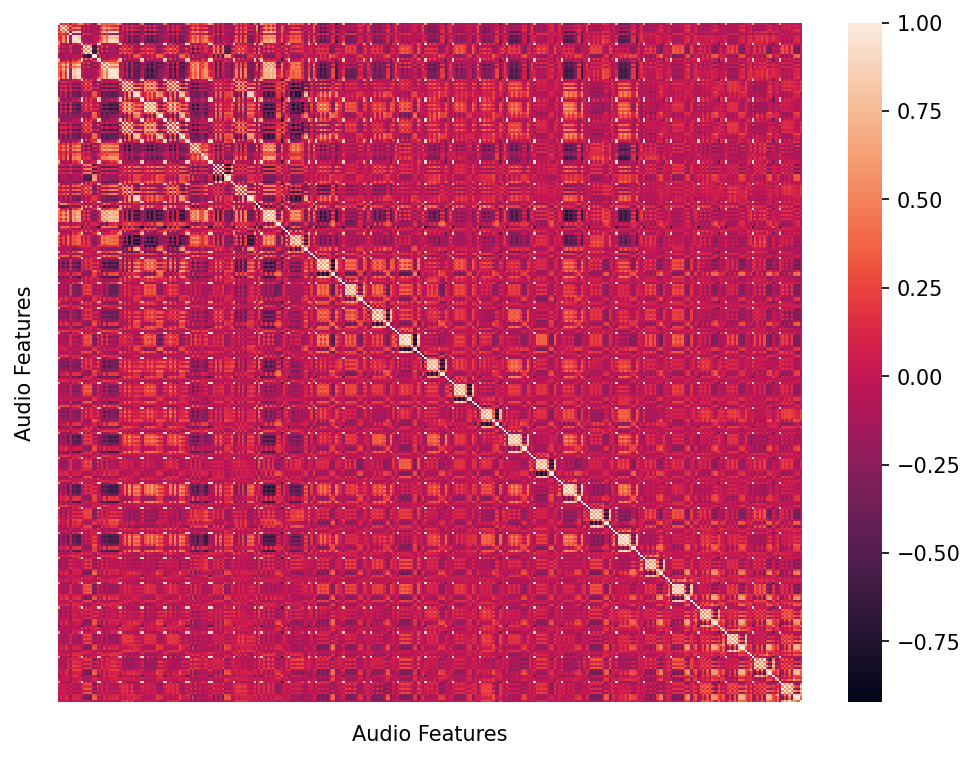

In [6]:
df_corr = df.iloc[:,4:].corr()
plt.figure(figsize=(8, 6))
g = sns.heatmap(df_corr, annot=False, fmt=".1f")
g.set_yticklabels([])
g.set_xticklabels([])
g.tick_params(left=False, bottom=False)
# plt.title("Correlation Matrix of Audio Features")
plt.xlabel("Audio Features")
plt.ylabel("Audio Features")
plt.show()

In [7]:
def hight_corr_feat_elimination(df_corr, high_corr):
    corr_pairs = df_corr.unstack()
    # order pairs of features with highest correlations
    strong_pairs = []
    for pair in corr_pairs.items():
        if pair[0][0] != pair[0][1] and abs(pair[1]) > high_corr\
            and ((pair[0][1], pair[0][0]), abs(pair[1])) not in strong_pairs:
            strong_pairs.append(((pair[0][0], pair[0][1]), abs(pair[1])))
    strong_pairs.sort(reverse=True, key=lambda x: abs(x[1]))

    eliminated_feats = set()

    for pair in strong_pairs:
        corr = pair[1]
        f1 = pair[0][0]
        f2 = pair[0][1]

        if corr > high_corr and \
            f1 not in eliminated_feats and \
            f2 not in eliminated_feats:
            mean_corr_f1 = np.mean(abs(df_corr[f1].values))
            mean_corr_f2 = np.mean(abs(df_corr[f2].values))

            eliminated_feats.add(f1 if mean_corr_f1 > mean_corr_f2 else f2)

    return eliminated_feats

In [8]:
df_corr = df.iloc[:,4:].corr()
eliminated_feats = hight_corr_feat_elimination(df_corr, 0.55)
print(len(eliminated_feats))
print(eliminated_feats)

234
{'mean_mfcc7', '75thpercentile_mel_spect', 'min_mfcc16', '75thpercentile_rms', 'sum_mfcc11', 'median_spec_cont', 'median_mfcc6', 'sum_mfcc2', '25thpercentile_mfcc19', 'std_spec_cent', 'std_mfcc11', 'std_mfcc1', '75thpercentile_mfcc20', '75thpercentile_mfcc1', 'sum_mfcc6', 'sum_spec_bw', 'var_rms', 'median_mfcc9', 'std_mfcc8', 'mean_mfcc10', 'var_zcr', 'median_spec_cent', 'spikes_mfcc14', 'sum_mfcc17', 'sum_mfcc1', 'median_mfcc15', 'mean_mel_spect', 'spikes_zcr', 'sum_mfcc15', 'spikes_tonnetz', '25thpercentile_mfcc4', '25thpercentile_mfcc8', '75thpercentile_mfcc15', '75thpercentile_chroma_stft', 'spikes_mfcc2', '25thpercentile_mfcc20', 'std_mfcc16', 'mean_mfcc4', 'min_mfcc4', 'sum_mel_spect', 'spikes_mfcc8', '25thpercentile_mfcc11', 'mean_mfcc14', 'mean_mfcc17', '75thpercentile_mfcc16', 'mean_mfcc9', 'spikes_chroma_stft', 'min_spec_bw', 'min_mfcc10', 'sum_mfcc5', 'median_spec_rolloff', 'mean_chroma_stft', 'sum_spec_rolloff', 'mean_spec_cent', 'min_tonnetz', 'sum_mfcc16', '75thpercen

In [9]:
[df.drop(feat, inplace=True, axis=1) for feat in eliminated_feats]
num_features = len(df.columns)-4
print(f"Number of features after high correlation elimination: {num_features}")
print(set(df.columns[4:]))

Number of features after high correlation elimination: 93
{'mean_mfcc16', '75thpercentile_mfcc17', 'skew_mfcc8', 'max_mfcc3', 'kurtosis_mfcc3', 'kurtosis_mfcc14', 'max_mfcc8', 'skew_mfcc6', 'var_mfcc12', '75thpercentile_spec_cent', 'max_mfcc14', 'var_mfcc8', 'var_mfcc4', '75thpercentile_mfcc19', 'skew_mfcc15', 'min_mel_spect', 'max_mfcc13', 'skew_mfcc19', 'kurtosis_mfcc19', 'skew_mfcc12', 'median_mfcc19', 'var_spec_bw', 'skew_mfcc17', 'skew_mfcc13', 'max_mfcc9', 'skew_mfcc18', 'kurtosis_mfcc20', 'kurtosis_mfcc5', 'kurtosis_mfcc16', 'max_mfcc12', 'skew_mfcc5', 'skew_mfcc11', 'var_mel_spect', 'min_zcr', 'median_chroma_stft', 'mean_tonnetz', 'var_mfcc1', '75thpercentile_tonnetz', 'kurtosis_mfcc10', 'var_mfcc14', 'max_mfcc10', 'var_mfcc5', 'max_mfcc5', 'var_mfcc15', 'kurtosis_mfcc18', 'skew_mfcc16', 'max_mfcc19', 'skew_mfcc20', 'min_mfcc14', 'kurtosis_mfcc9', 'kurtosis_mfcc17', 'mean_mfcc15', 'kurtosis_mfcc4', 'skew_mfcc3', '25thpercentile_mel_spect', 'var_mfcc11', '75thpercentile_mfcc12',

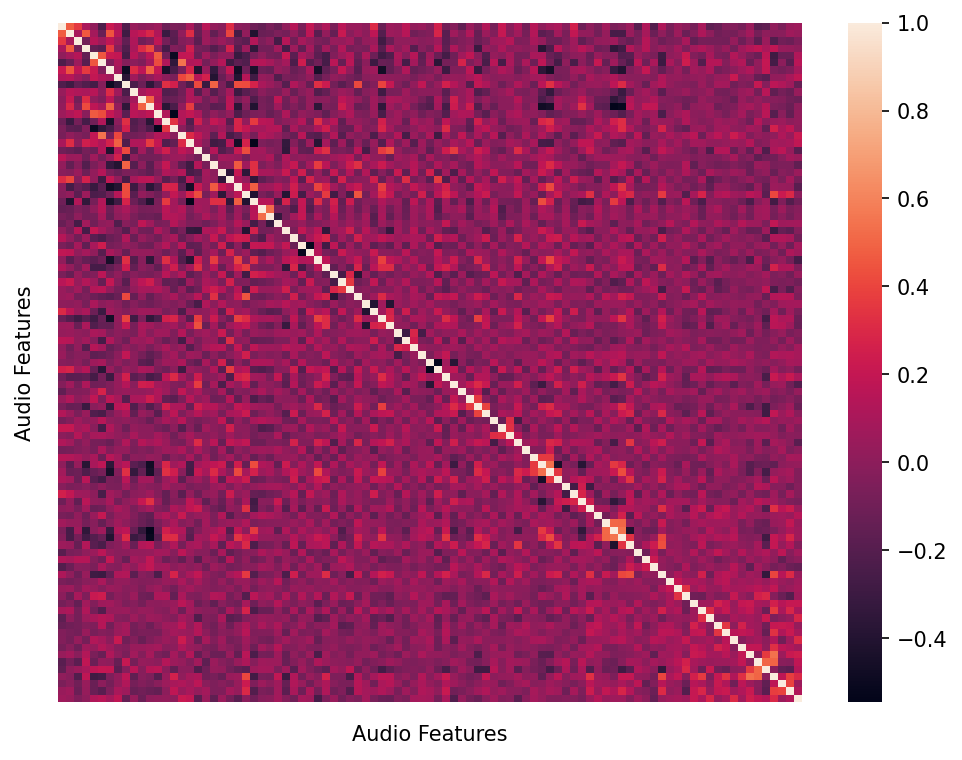

In [10]:
plt.figure(figsize=(8, 6))
df_corr = df.iloc[:,4:].corr()
g = sns.heatmap(df_corr, annot=False, fmt=".2f")
g.set_yticklabels([])
g.set_xticklabels([])
g.tick_params(left=False, bottom=False)
plt.xlabel("Audio Features")
plt.ylabel("Audio Features")
plt.show()

In [11]:
data = df.iloc[:,4:]
features = df.columns.values[4:]
labels = df["Emotion_Id"].values

## Compare Scores of Classifiers

In [12]:
def compare_clfs(clfs, data, labels):
    clfs_scores = defaultdict(dict)
    
    for clf in clfs:
        start_time = time.time()
        scores = cross_val_score(clf, data, labels, cv=5)
        total_time = time.time() - start_time

        # scores for each fold
        mean_score = np.mean(scores)
        std_score = np.std(scores)

        clfs_scores[clf.__class__.__name__.split("(")[0]] = (mean_score, std_score, total_time)
    
    return clfs_scores

In [1]:
%%capture
clfs = [
    DecisionTree(random_state=1),
    ExtraTree(random_state=1),
    RandomForest(random_state=1, n_estimators=200),
    AdaBoostClassifier(random_state=1, n_estimators=200),
    svm.SVC(decision_function_shape='ovo', random_state=1),
    ExtraTrees(random_state=1, n_estimators=200),
    XGB(random_state=1, objective="multi:softprob"),
    Ridge(random_state=1),
    MLPClassifier(random_state=1)
]

clfs_scores = compare_clfs(clfs, data, labels)

NameError: name 'DecisionTree' is not defined

In [22]:
print(f"Classifiers Ordered by Highest Mean Accuracy:")
print(tabulate(
    pd.DataFrame().from_dict(dict(
        sorted(clfs_scores.items(), key=lambda item: item[1][0], reverse=True)
    ), orient="index", columns=["Mean Accuracy", "Std Accuracy", "CV Time"]), headers = 'keys'
))

Classifiers Ordered by Highest Mean Accuracy:
                          Mean Accuracy    Std Accuracy     CV Time
----------------------  ---------------  --------------  ----------
RidgeClassifier                0.628571       0.0170865   0.0275385
ExtraTreesClassifier           0.608333       0.0306764   2.64233
XGBClassifier                  0.602381       0.0424918   1.74764
RandomForestClassifier         0.57619        0.0596902  13.7922
AdaBoostClassifier             0.575          0.0194161   1.81572
DecisionTreeClassifier         0.434524       0.0246862   0.206599
ExtraTreeClassifier            0.403571       0.0397341   0.0378432
MLPClassifier                  0.307143       0.0239874   0.524464
SVC                            0.27619        0.0256988   0.197176

Classifiers Ordered by Lowest Standard Deviation Accuracy:
                          Mean Accuracy    Std Accuracy     CV Time
----------------------  ---------------  --------------  ----------
RidgeClassifier       

In [23]:
print(f"Classifiers Ordered by Highest Mean Accuracy:")
print(tabulate(
    pd.DataFrame().from_dict(dict(
        sorted(clfs_scores.items(), key=lambda item: item[1][0], reverse=True)
    ), orient="index", columns=["Mean Accuracy", "Std Accuracy", "CV Time"]), headers='keys', tablefmt="latex_booktabs"
))

Classifiers Ordered by Highest Mean Accuracy:
\begin{tabular}{lrrr}
\toprule
                        &   Mean Accuracy &   Std Accuracy &    CV Time \\
\midrule
 RidgeClassifier        &        0.628571 &      0.0170865 &  0.0275385 \\
 ExtraTreesClassifier   &        0.608333 &      0.0306764 &  2.64233   \\
 XGBClassifier          &        0.602381 &      0.0424918 &  1.74764   \\
 RandomForestClassifier &        0.57619  &      0.0596902 & 13.7922    \\
 AdaBoostClassifier     &        0.575    &      0.0194161 &  1.81572   \\
 DecisionTreeClassifier &        0.434524 &      0.0246862 &  0.206599  \\
 ExtraTreeClassifier    &        0.403571 &      0.0397341 &  0.0378432 \\
 MLPClassifier          &        0.307143 &      0.0239874 &  0.524464  \\
 SVC                    &        0.27619  &      0.0256988 &  0.197176  \\
\bottomrule
\end{tabular}

Classifiers Ordered by Lowest Standard Deviation Accuracy:
\begin{tabular}{lrrr}
\toprule
                        &   Mean Accuracy &   S

## Custom Feature Elimination with Propagation

In [102]:
def feature_elim(data, features, labels, n_features=1):
    data_c = data.copy()
    features = list(features)
    total_features = len(features)
    results = pd.DataFrame(columns=["Mean Acc", "Std Acc"])

    for _ in range(total_features-1, n_features-1, -1):
        acc = pd.DataFrame(columns=["Feature", "Mean Acc", "Std Acc"])
        
        for feat in tqdm(features):
            X_train = data_c.copy()

            X_train.drop(feat, inplace=True, axis=1)

            clf = Ridge(random_state=1)
            scores = cross_val_score(clf, X_train, labels, cv=5)

            # mean score across all folds
            mean_score = np.mean(scores)
            std_score = np.std(scores)

            acc.loc[feat] = [feat, mean_score, std_score]

        acc_scaled = acc.copy(deep=True)
        acc_scaled[acc_scaled.columns[1]] = minmax_scale(acc_scaled[acc_scaled.columns[1]], (0, 1))
        acc_scaled[acc_scaled.columns[2]] = minmax_scale(acc_scaled[acc_scaled.columns[2]], (0, 1))
        acc_scaled = acc_scaled.values.tolist()
        worse_feat = sorted(acc_scaled, key=lambda x: x[1]*0.5 - x[2]*0.5, reverse=True)[0]
        worse_feat = acc.loc[acc['Feature'] == worse_feat[0]].values[0]
        data_c.drop(worse_feat[0], inplace=True, axis=1)
        features.remove(worse_feat[0])
        results.loc[worse_feat[0]] = [worse_feat[1], worse_feat[2]]

    return results

In [103]:
custom_feat_elim_df = feature_elim(data, features, labels, 1)
custom_feat_elim_df.to_csv("custom_feat_elim.csv")
custom_feat_elim_df

100%|██████████| 2/2 [00:00<00:00, 64.55it/s]


,Mean Acc,Std Acc
kurtosis_mfcc10,0.630952,0.009960
skew_mfcc4,0.632143,0.008748
skew_mfcc16,0.633333,0.004762
skew_mfcc8,0.634524,0.004762
skew_mfcc19,0.636905,0.006521
var_mfcc6,0.644048,0.007897
kurtosis_mfcc16,0.646429,0.006070
max_mfcc14,0.647619,0.004454
min_spec_cont,0.650000,0.002381
25thpercentile_mel_spect,0.650000,0.002381


In [104]:
def energy_method(df, energy_perc, col1, col2=None):
    eliminated_feats = []
    cumulative_energy = 0

    if col2:
        total = 0

        arr1 = minmax_scale(list(df[col1].values), (0, 1))
        arr2 = minmax_scale(list(df[col2].values), (0, 1))

        for i, _ in enumerate(df.iterrows()):
            total += arr1[i]*0.5 - arr2[i]*0.5

        for i, feat_cols in enumerate(df.iterrows()):
            feat = feat_cols[0]
            val = arr1[i]*0.5 - arr2[i]*0.5
            cumulative_energy += val
            eliminated_feats.append(feat)
            if (cumulative_energy * 100 / total) >= energy_perc:
                break
    else:
        total = np.sum(df[col1].values)
        i = 0
        for feat, columns in df.iterrows():
            i += 1
            val = columns[col1]
            cumulative_energy += val
            eliminated_feats.append(feat)
            if (cumulative_energy * 100 / total) >= energy_perc:
                break
        
    return eliminated_feats, i

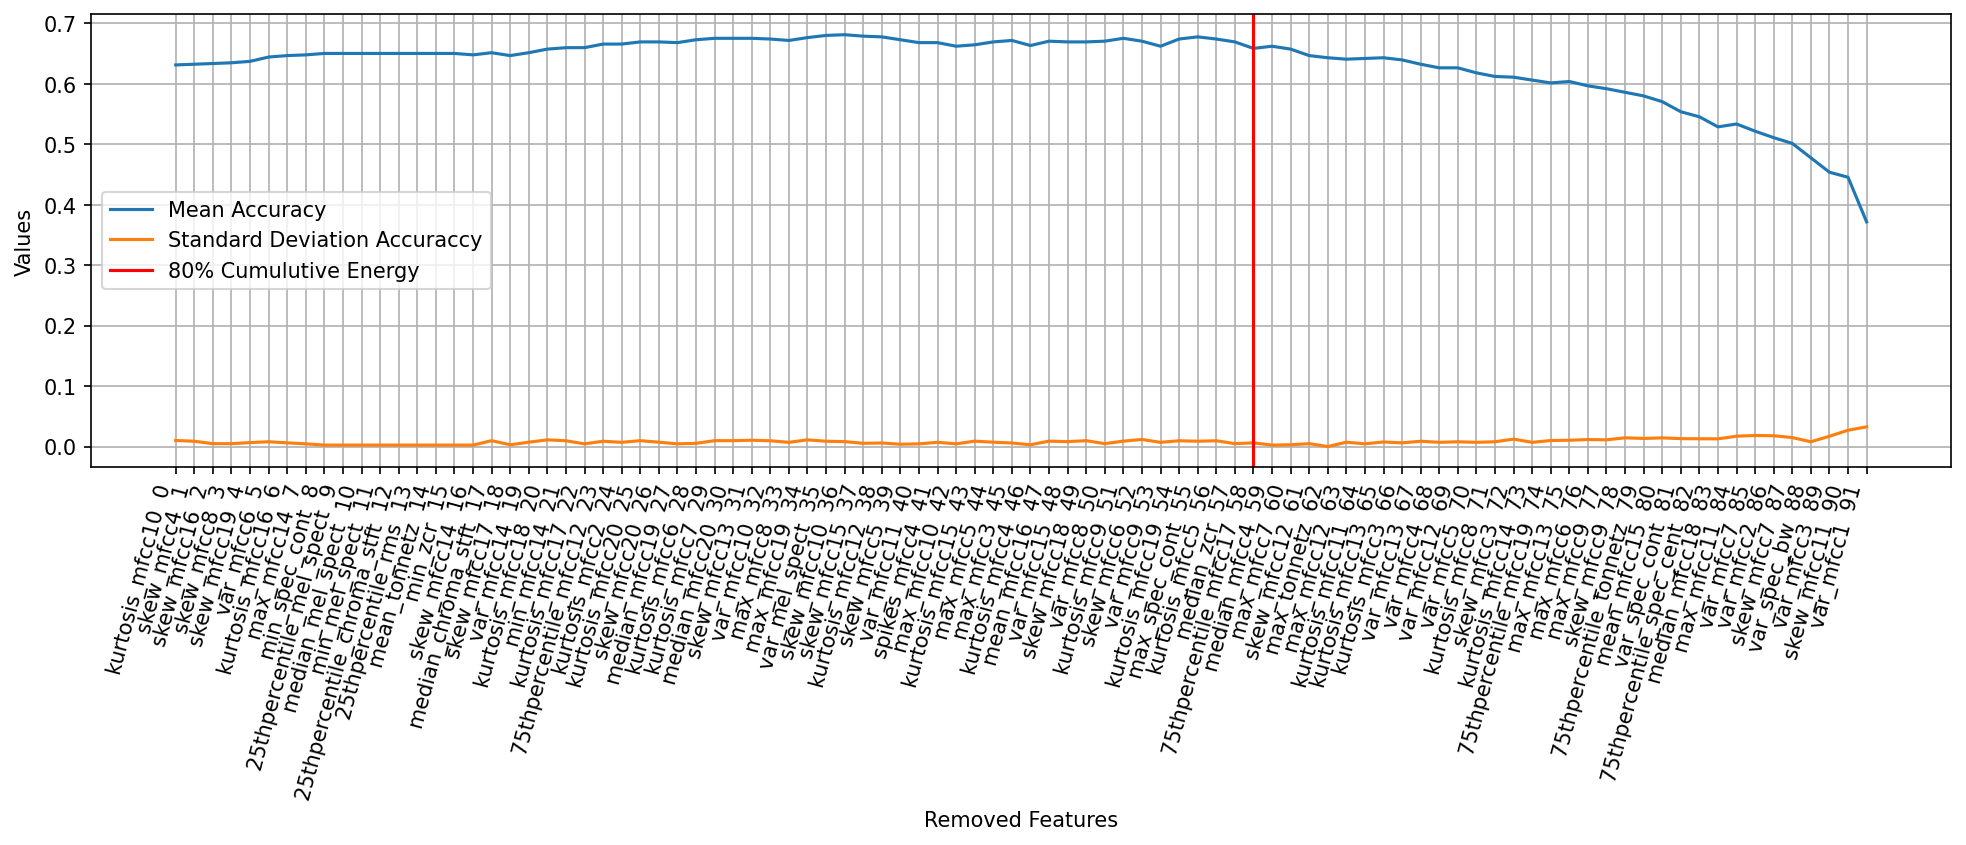

In [105]:
custom_feat_elim_df = pd.read_csv("custom_feat_elim.csv", index_col=0)
custom_elim_feats, custom_i = energy_method(custom_feat_elim_df, 80, "Mean Acc", "Std Acc")
fig = plt.figure(figsize=(16,4))
ax = plt.axes()
plt.ylabel("Values")
plt.xlabel("Removed Features")
plt.grid()
plt.setp(ax.get_xticklabels(), ha="right", rotation=75)
x_labels = [f"{custom_feat_elim_df.index.values[i]}  {i}" for i in range(len(custom_feat_elim_df.index.values))]
ax.plot(x_labels, custom_feat_elim_df['Mean Acc'].values, label="Mean Accuracy")
ax.plot(x_labels, custom_feat_elim_df['Std Acc'].values, label="Standard Deviation Accuraccy")
ax.axvline(x = custom_i, color = 'r', label="80% Cumulutive Energy")
plt.legend()

## Feature Elimination with Backward Propagation

- Less 1 feature

In [106]:
sfs1 = sfs(Ridge(random_state=1), k_features=num_features-1, forward=False, cv=5, n_jobs=8)
sfs1 = sfs1.fit(data, labels)
print(sfs1.k_score_)
feat_names = set(sfs1.k_feature_names_)
left_out_features = [feat for feat in features if feat not in feat_names]
print(left_out_features)

0.6357142857142858
['max_mfcc10']


- For All Features

In [107]:
feat_elim = {}
df_train = data.copy()
for i in range(num_features-1, 0, -1):
    sfs1 = sfs(Ridge(random_state=1), k_features=i, forward=False, cv=5, n_jobs=8)
    sfs1 = sfs1.fit(df_train, labels)
    feat_names = set(sfs1.k_feature_names_)
    eliminated_f = [feat for feat in features if feat not in feat_names and feat not in feat_elim][0]
    feat_elim[eliminated_f] = sfs1.k_score_
    df_train.drop(eliminated_f, inplace=True, axis=1)

In [108]:
feat_elim_df = pd.DataFrame().from_dict(feat_elim, orient="index", columns=["Accuracy"])
feat_elim_df.to_csv('feat_elim.csv')
print(tabulate(feat_elim_df.iloc[:10,:], headers = 'keys'))

                              Accuracy
--------------------------  ----------
max_mfcc10                    0.635714
skew_mfcc10                   0.640476
kurtosis_mfcc8                0.645238
median_mfcc20                 0.645238
max_mfcc19                    0.65119
mean_tonnetz                  0.65119
25thpercentile_rms            0.65119
25thpercentile_chroma_stft    0.65119
min_mel_spect                 0.65119
median_mel_spect              0.65119


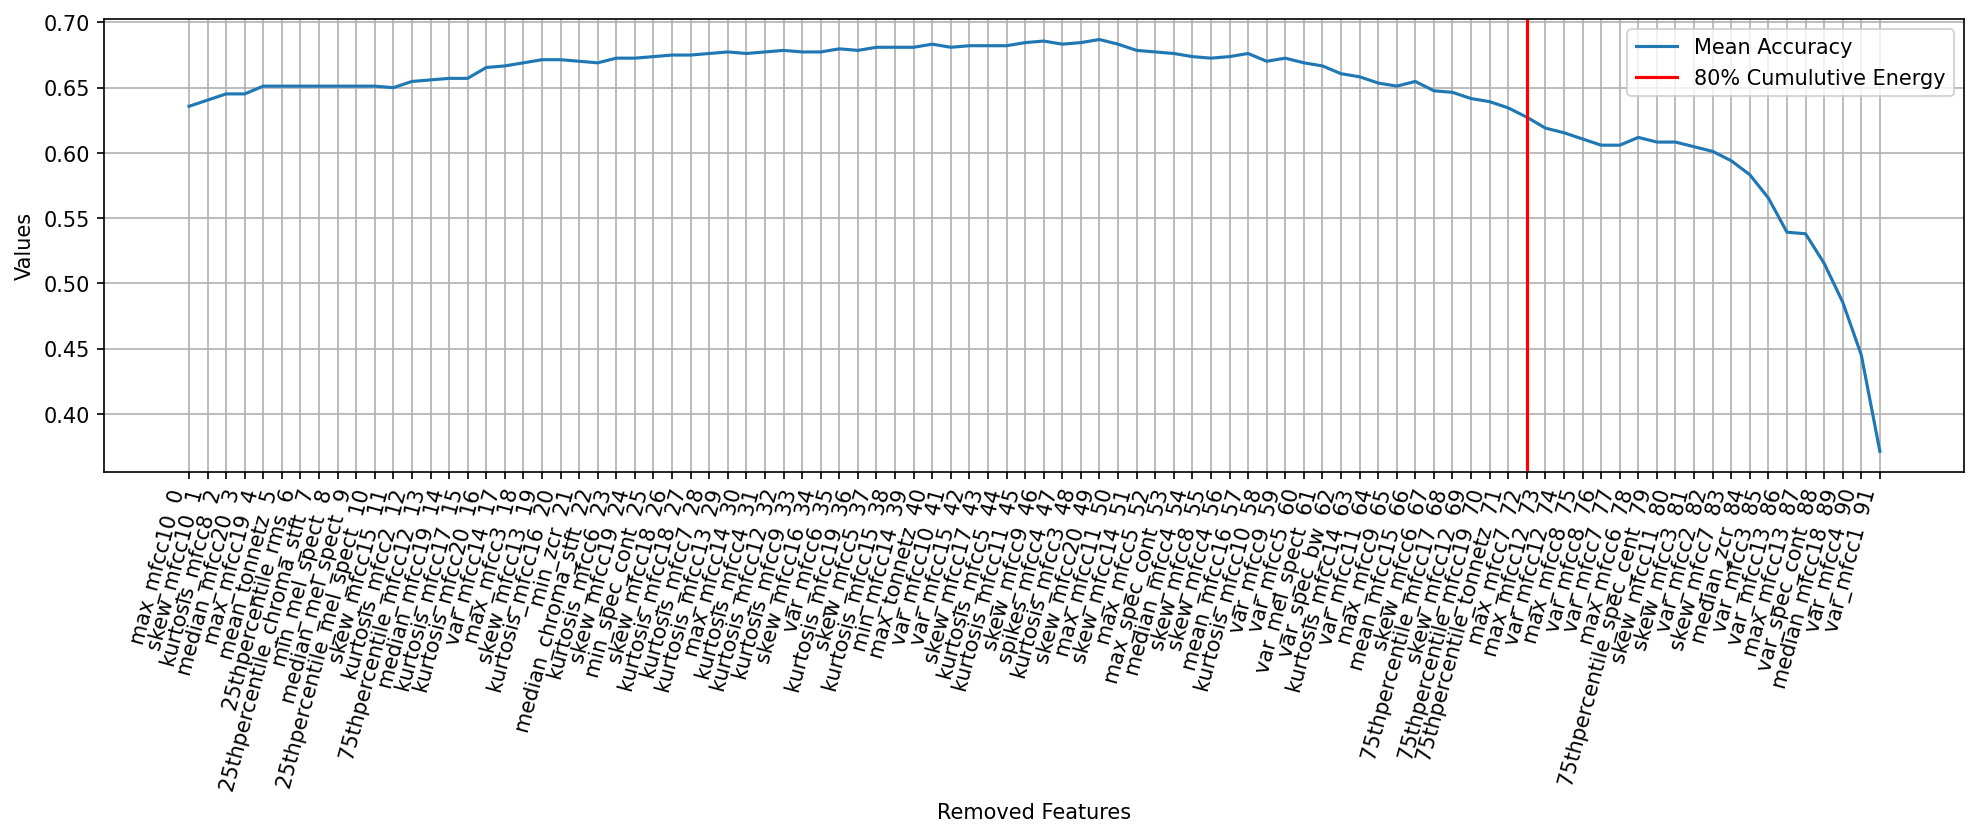

In [109]:
feat_elim_df = pd.read_csv("feat_elim.csv", index_col=0)
elim_feats, i = energy_method(feat_elim_df, 80, "Accuracy")
fig = plt.figure(figsize=(16,4))
ax = plt.axes()
plt.ylabel("Values")
plt.xlabel("Removed Features")
plt.grid()
plt.setp(ax.get_xticklabels(), ha="right", rotation=75)
x_labels = [f"{feat_elim_df.index.values[i]}  {i}" for i in range(len(feat_elim_df.index.values))]
ax.plot(x_labels, feat_elim_df['Accuracy'].values, label="Mean Accuracy")
ax.axvline(x = i, color = 'r', label="80% Cumulutive Energy")
plt.legend()

In [110]:
common_elim_feats = [x for x in custom_elim_feats if x in elim_feats]
print('Feature Elimination with Propagation - Keeping 80% "Energy"\n')

print(f"Number of Eliminated Features Using:\n\t-Mean Accuracy as the Decider Metric: {len(elim_feats)}")
print(f"\t-Mean and Standard Deviation Accuracy as the Decider Metrics: {len(custom_elim_feats)}\n")
print(f"Common Eliminated Features betwen the two: {len(common_elim_feats)}")

Feature Elimination with Propagation - Keeping 80% "Energy"

Number of Eliminated Features Using:
	-Mean Accuracy as the Decider Metric: 72
	-Mean and Standard Deviation Accuracy as the Decider Metrics: 59

Common Eliminated Features betwen the two: 56


In [111]:
data_elim_feats = data.copy(deep=True)
[data_elim_feats.drop(feat, inplace=True, axis=1) for feat in common_elim_feats]
num_features = len(data_elim_feats.columns)
features = data_elim_feats.columns.values
print(f"Number of Features After Eliminating Common Features: {num_features}")
print(set(features))

Number of Features After Eliminating Common Features: 37
{'max_mfcc7', 'median_mfcc4', 'kurtosis_mfcc14', 'var_mfcc7', 'max_mfcc6', 'skew_mfcc3', 'kurtosis_mfcc11', 'var_mfcc4', 'median_mfcc18', 'max_mfcc8', 'var_mfcc2', 'max_mfcc12', 'skew_mfcc7', 'var_mfcc13', 'kurtosis_mfcc3', 'var_mfcc8', 'var_mfcc5', 'sum_mfcc3', 'max_mfcc11', 'median_zcr', 'var_mfcc1', 'mean_mfcc15', 'var_mfcc12', '75thpercentile_spec_cent', 'max_mfcc13', 'skew_mfcc9', 'max_tonnetz', 'kurtosis_mfcc13', 'var_spec_bw', 'skew_mfcc11', 'var_mfcc3', '75thpercentile_mfcc19', 'var_spec_cont', 'skew_mfcc12', 'kurtosis_mfcc8', '75thpercentile_tonnetz', 'max_mfcc9'}


## PCA

In [112]:
pca = PCA(random_state=1)
data_scaled = StandardScaler().fit_transform(data)
data_pca = pca.fit_transform(data_scaled)
explained_variance = pca.explained_variance_ratio_
list(explained_variance).sort(reverse=True)
comp_var = {}
for i in range(1, len(explained_variance)+1):
    comp_var[i] = np.sum(explained_variance[:i])
pd.DataFrame().from_dict(comp_var, orient='index', columns=["Total Variance Ratio"])

,Total Variance Ratio
1,0.086412
2,0.168021
3,0.221672
4,0.265384
5,0.300279
6,0.328133
7,0.353732
8,0.377190
9,0.399780
10,0.420075


In [113]:
min_var = .9
threshold = 0.01
prev_exp_var = 0
for num_component, total_exp_var in comp_var.items():
    if total_exp_var >= min_var and abs(total_exp_var - prev_exp_var) <= threshold:
        break
    prev_exp_var = total_exp_var
num_component

57

In [114]:
pca = PCA(random_state=1)
data_scaled_elim = StandardScaler().fit_transform(data_elim_feats)
data_pca_elim = pca.fit_transform(data_scaled_elim)
explained_variance = pca.explained_variance_ratio_
list(explained_variance).sort(reverse=True)
comp_var_elim = {}
for i in range(1, len(explained_variance)+1):
    comp_var_elim[i] = np.sum(explained_variance[:i])
pd.DataFrame().from_dict(comp_var_elim, orient='index', columns=["Total Variance Ratio"])

,Total Variance Ratio
1,0.117600
2,0.209626
3,0.280437
4,0.335921
5,0.382011
6,0.424100
7,0.464716
8,0.503907
9,0.537284
10,0.568996


In [115]:
min_var = .9
threshold = 0.04
prev_exp_var = 0
for num_component_elim, total_exp_var in comp_var_elim.items():
    if total_exp_var >= min_var and abs(total_exp_var - prev_exp_var) <= threshold:
        break
    prev_exp_var = total_exp_var
num_component_elim

26

# Confusion Matrix for Predictions

In [120]:
def get_tick_labels(val, aro):
    if val and aro:
        return [
            '(0, 0) - sadness',
            '(0, 1) - anger',
            '(1, 1) - happiness, surprise'
        ]
    elif val:
        return [
            '0 - Low Valence',
            '1 - High Valence'
        ]
    elif aro:
        return [
            '0 - Low Arousal',
            '1 - High Arousal'
        ]
    else:
        return [
            '0 - anger',
            '1 - happiness',
            '2 - sadness',
            '3 - surprise'
        ]

In [117]:
'''
calculate multi-class classification and return related evaluation metrics
'''
def multi_class_classification(y_pred, labels):
    print("accuracy: ", metrics.accuracy_score(labels, y_pred))
    print("f1 score macro: ", metrics.f1_score(labels, y_pred, average='macro') )
    print("f1 score micro: ", metrics.f1_score(labels, y_pred, average='micro') )
    print("precision score: ", metrics.precision_score(labels, y_pred, average='macro') )
    print("recall score: ", metrics.recall_score(labels, y_pred, average='macro') )
    print("hamming_loss: ", metrics.hamming_loss(labels, y_pred))
    print("matthews_corrcoef: ", metrics.matthews_corrcoef(labels, y_pred) )
    print("zero_one_loss: ", metrics.zero_one_loss(labels, y_pred))

In [118]:
def plot_cm_predictions(clf, input_data, labels, cv=5, val=False, aro=False, scoring='accuracy', draw_corr_matrix=True, one_hot_encoding=pd.DataFrame()):
    if one_hot_encoding.empty:
        y_pred = cross_val_predict(clf, input_data, labels, cv=cv)
    else:
        y_pred = cross_val_predict(clf, input_data, one_hot_encoding, cv=cv)
        y_pred = y_pred.argmax(1)
        
    ticks = get_tick_labels(val, aro)

    multi_class_classification(y_pred, labels)
    print(metrics.classification_report(labels, y_pred, target_names=ticks))

    if draw_corr_matrix:
        cm = metrics.confusion_matrix(labels, y_pred)
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, fmt="d", xticklabels=ticks, yticklabels=ticks)
        plt.title("Confusion Matrix Predicted Labels")
        plt.xlabel("Emotions Labels")
        plt.ylabel("Emotions Labels")
        plt.yticks(rotation=0) 
        plt.show()

## 1 - With all initial features

In [127]:
df[df.columns[4:]].shape

(840, 327)

accuracy:  0.6202380952380953
f1 score macro:  0.6195480869931024
f1 score micro:  0.6202380952380953
precision score:  0.6195728564818828
recall score:  0.6202380952380953
hamming_loss:  0.37976190476190474
matthews_corrcoef:  0.49385894512196393
zero_one_loss:  0.37976190476190474
               precision    recall  f1-score   support

    0 - anger       0.69      0.70      0.69       210
1 - happiness       0.55      0.58      0.56       210
  2 - sadness       0.69      0.70      0.70       210
 3 - surprise       0.55      0.51      0.53       210

     accuracy                           0.62       840
    macro avg       0.62      0.62      0.62       840
 weighted avg       0.62      0.62      0.62       840



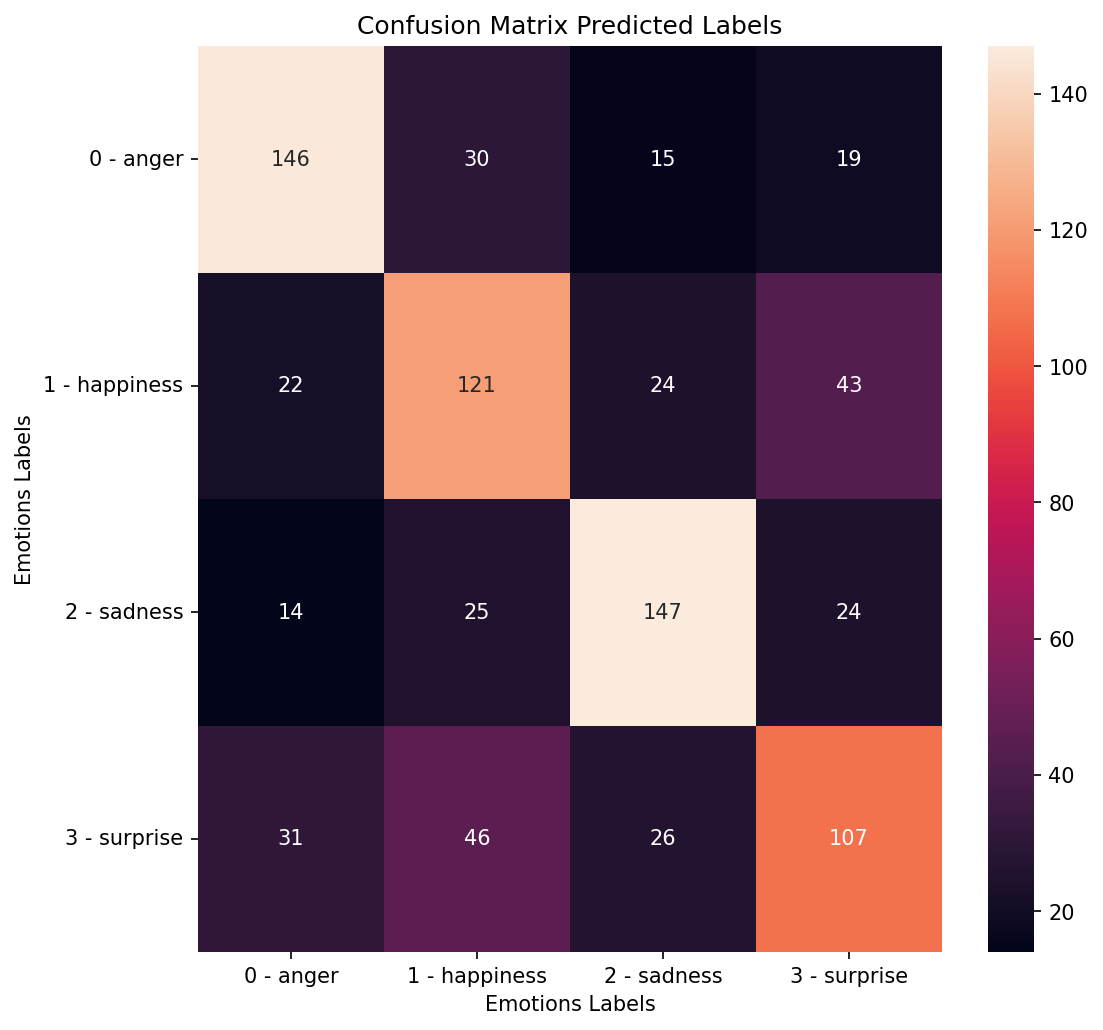

In [128]:
plot_cm_predictions(Ridge(random_state=1), df[df.columns[4:]].values, labels)

## 1.1 - With high correlation elimination

In [129]:
data.shape

(840, 93)

accuracy:  0.6285714285714286
f1 score macro:  0.6229746224223769
f1 score micro:  0.6285714285714286
precision score:  0.623364000107828
recall score:  0.6285714285714286
hamming_loss:  0.37142857142857144
matthews_corrcoef:  0.5063902922324037
zero_one_loss:  0.37142857142857144
               precision    recall  f1-score   support

    0 - anger       0.65      0.73      0.69       210
1 - happiness       0.61      0.55      0.58       210
  2 - sadness       0.67      0.76      0.71       210
 3 - surprise       0.57      0.47      0.51       210

     accuracy                           0.63       840
    macro avg       0.62      0.63      0.62       840
 weighted avg       0.62      0.63      0.62       840



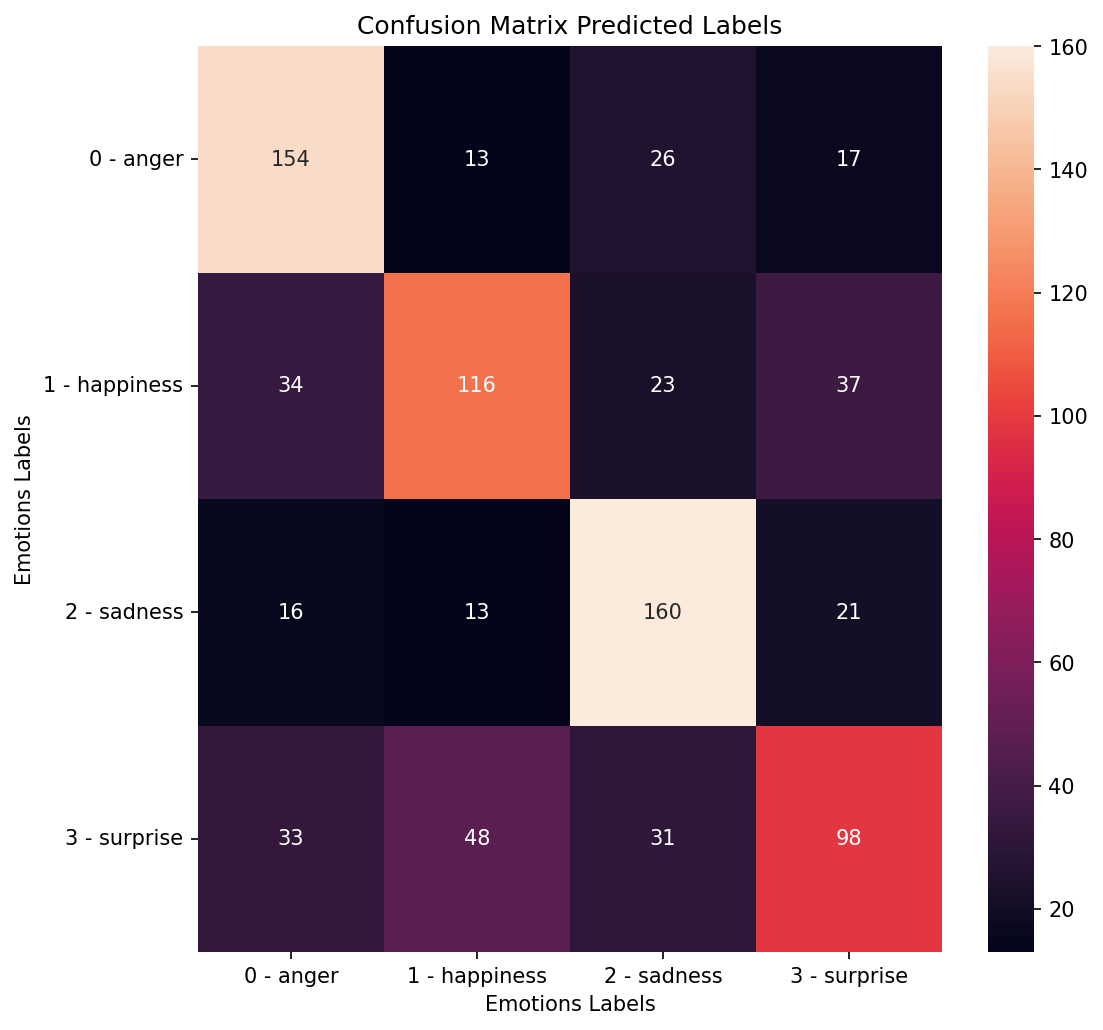

In [130]:
plot_cm_predictions(Ridge(random_state=1), data.values, labels)

## 1.1.1 With All Principal Components

In [133]:
data_pca.shape

(840, 93)

accuracy:  0.6392857142857142
f1 score macro:  0.632534140062996
f1 score micro:  0.6392857142857142
precision score:  0.6329919905055121
recall score:  0.6392857142857143
hamming_loss:  0.3607142857142857
matthews_corrcoef:  0.5210323460424469
zero_one_loss:  0.36071428571428577
               precision    recall  f1-score   support

    0 - anger       0.66      0.77      0.71       210
1 - happiness       0.61      0.57      0.59       210
  2 - sadness       0.69      0.77      0.73       210
 3 - surprise       0.57      0.45      0.51       210

     accuracy                           0.64       840
    macro avg       0.63      0.64      0.63       840
 weighted avg       0.63      0.64      0.63       840



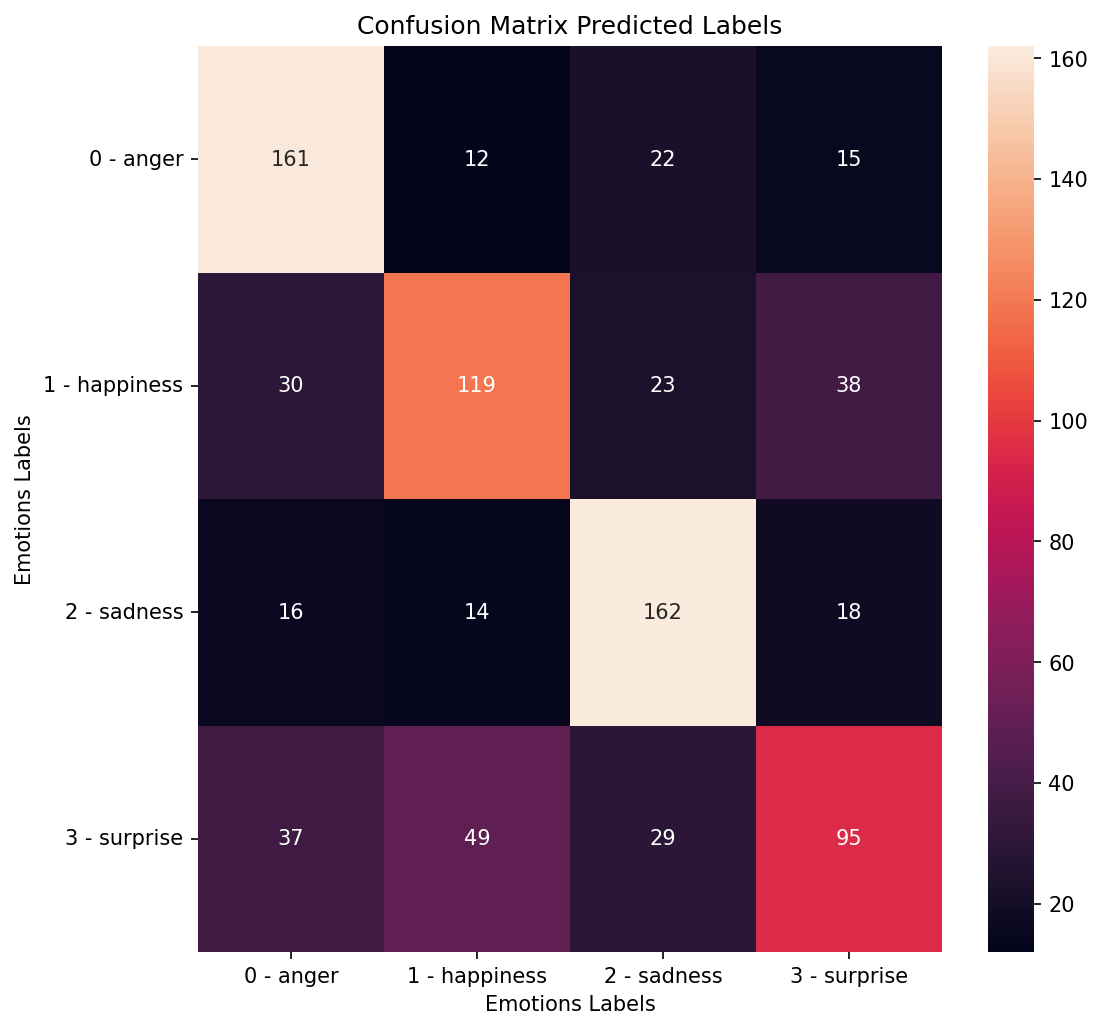

In [132]:
plot_cm_predictions(Ridge(random_state=1), data_pca, labels)

## 1.1.2 - With an Ideal Number of Principal Components

In [136]:
data_pca_ideal_comp.shape

(840, 57)

accuracy:  0.5845238095238096
f1 score macro:  0.5791095350661826
f1 score micro:  0.5845238095238096
precision score:  0.5771843728490496
recall score:  0.5845238095238094
hamming_loss:  0.4154761904761905
matthews_corrcoef:  0.4469617724811105
zero_one_loss:  0.41547619047619044
               precision    recall  f1-score   support

    0 - anger       0.62      0.67      0.65       210
1 - happiness       0.56      0.54      0.55       210
  2 - sadness       0.65      0.73      0.69       210
 3 - surprise       0.48      0.40      0.44       210

     accuracy                           0.58       840
    macro avg       0.58      0.58      0.58       840
 weighted avg       0.58      0.58      0.58       840



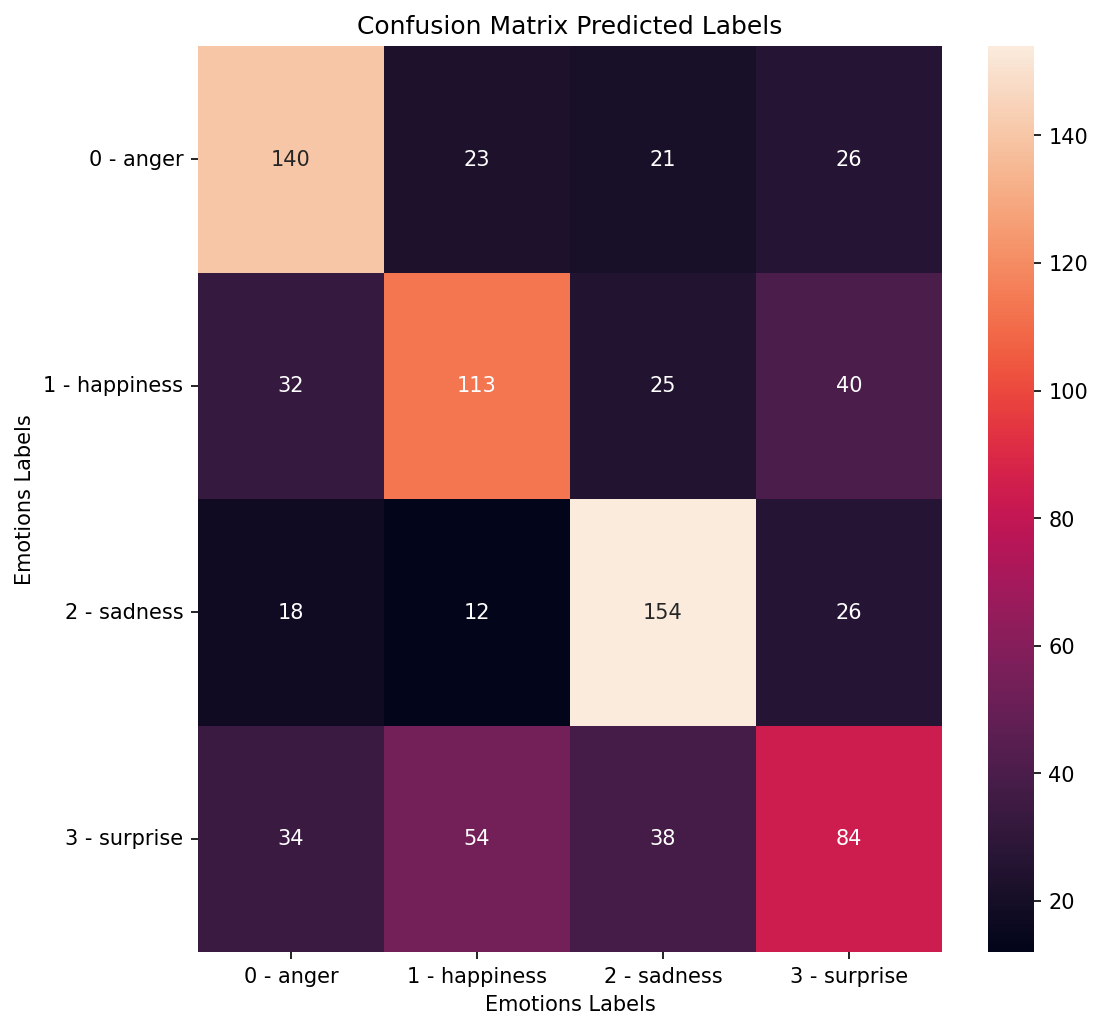

In [135]:
pca = PCA(n_components=num_component)
data_pca_ideal_comp = pca.fit_transform(data_scaled)
plot_cm_predictions(Ridge(random_state=1), data_pca_ideal_comp, labels)

## 1.1.3 - With Feature Elimination with Backward Propagation

In [137]:
data_elim_feats.shape

(840, 37)

accuracy:  0.6583333333333333
f1 score macro:  0.6532799820146907
f1 score micro:  0.6583333333333333
precision score:  0.653627521006594
recall score:  0.6583333333333333
hamming_loss:  0.3416666666666667
matthews_corrcoef:  0.5459226652206823
zero_one_loss:  0.3416666666666667
               precision    recall  f1-score   support

    0 - anger       0.71      0.77      0.74       210
1 - happiness       0.61      0.60      0.60       210
  2 - sadness       0.68      0.78      0.73       210
 3 - surprise       0.61      0.49      0.54       210

     accuracy                           0.66       840
    macro avg       0.65      0.66      0.65       840
 weighted avg       0.65      0.66      0.65       840



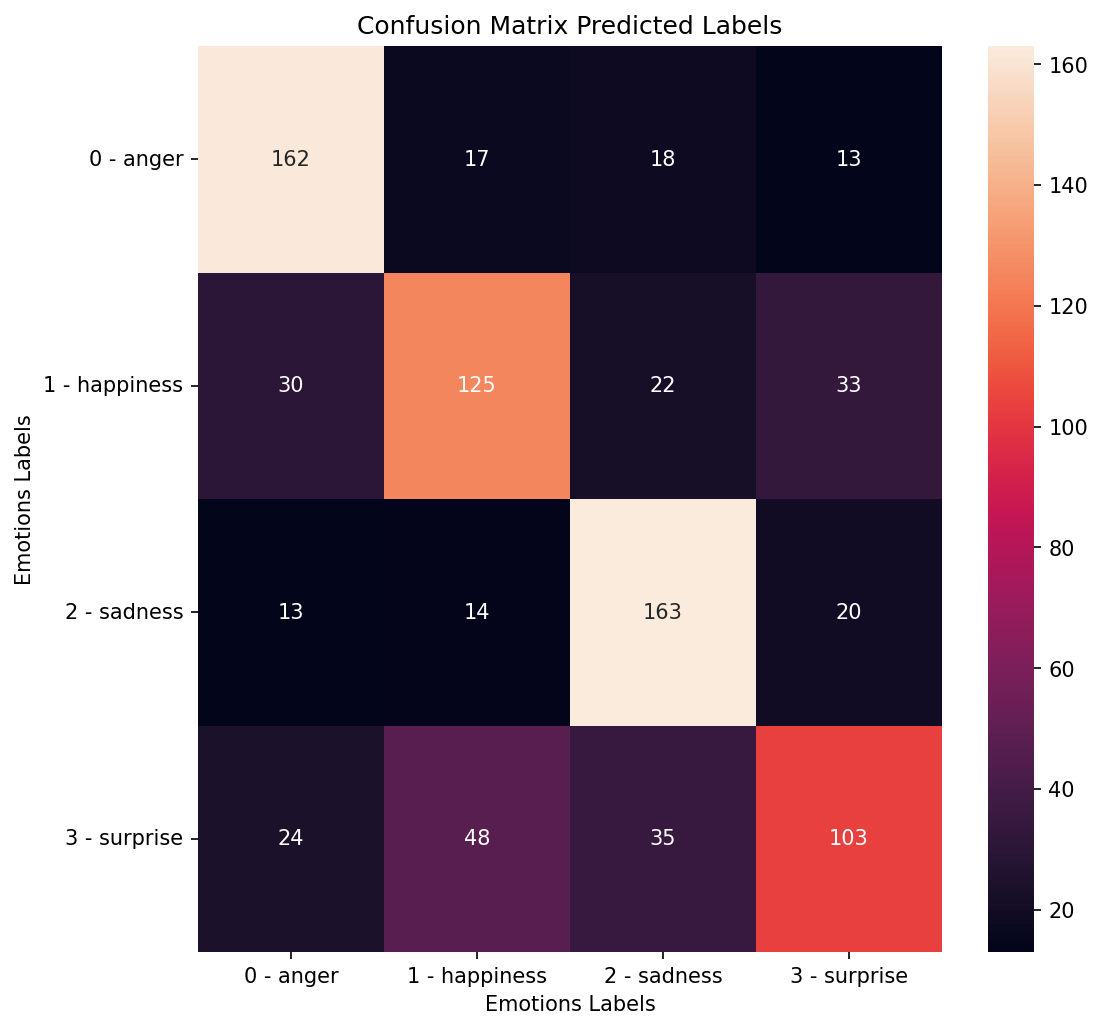

In [138]:
plot_cm_predictions(Ridge(random_state=1), data_elim_feats.values, labels)

## 1.1.3.1 - With All Principal Components

accuracy:  0.6666666666666666
f1 score macro:  0.6628820978691499
f1 score micro:  0.6666666666666666
precision score:  0.662714625067435
recall score:  0.6666666666666666
hamming_loss:  0.3333333333333333
matthews_corrcoef:  0.5565618946270158
zero_one_loss:  0.33333333333333337
               precision    recall  f1-score   support

    0 - anger       0.73      0.78      0.75       210
1 - happiness       0.63      0.61      0.62       210
  2 - sadness       0.69      0.76      0.72       210
 3 - surprise       0.61      0.51      0.56       210

     accuracy                           0.67       840
    macro avg       0.66      0.67      0.66       840
 weighted avg       0.66      0.67      0.66       840



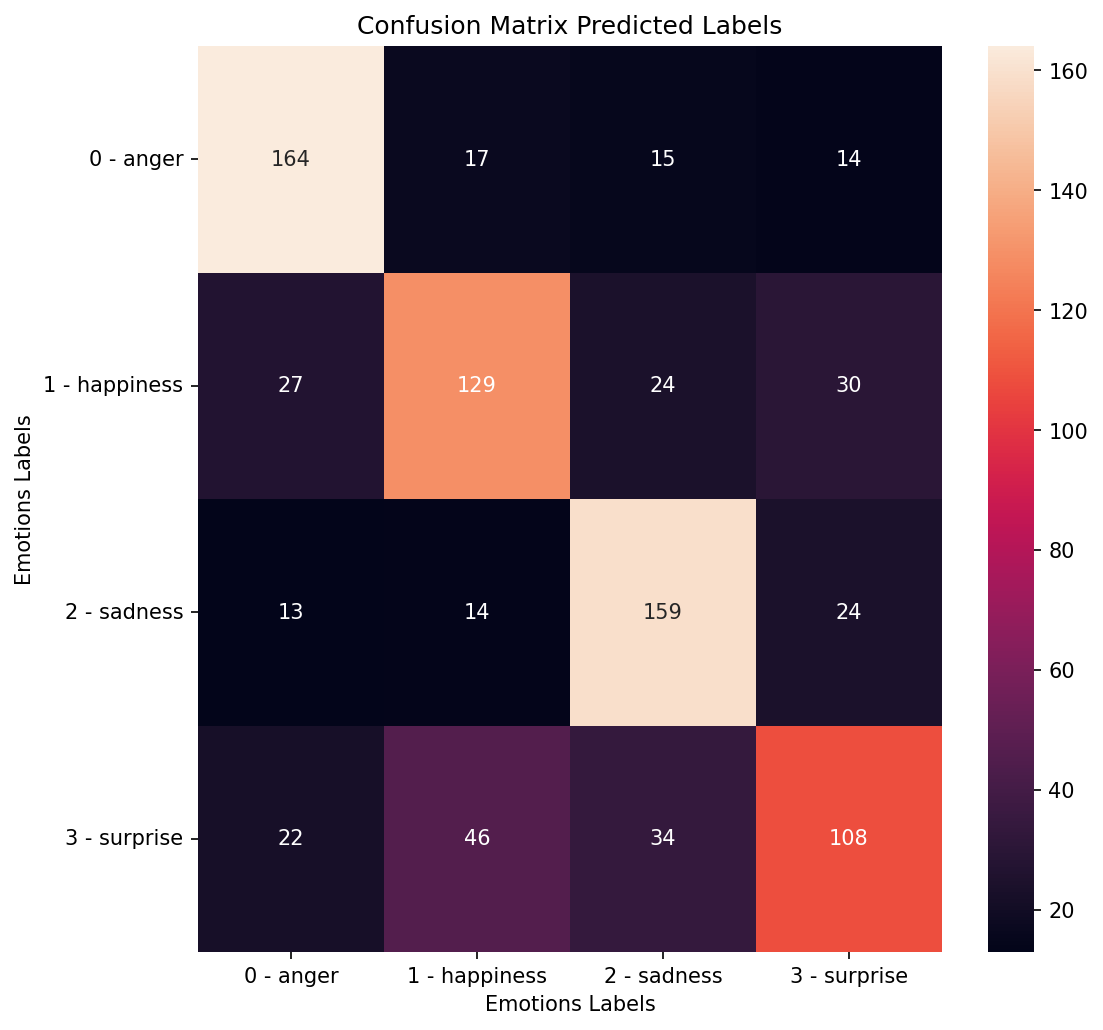

In [139]:
plot_cm_predictions(
    Ridge(random_state=1),
    data_pca_elim, labels
)

## 1.3.1.2 - With an Ideal Number of Principal Components

accuracy:  0.5619047619047619
f1 score macro:  0.5583440502986708
f1 score micro:  0.5619047619047619
precision score:  0.5566783420434788
recall score:  0.5619047619047619
hamming_loss:  0.4380952380952381
matthews_corrcoef:  0.41637135466018443
zero_one_loss:  0.4380952380952381
               precision    recall  f1-score   support

    0 - anger       0.59      0.65      0.62       210
1 - happiness       0.51      0.50      0.50       210
  2 - sadness       0.67      0.70      0.69       210
 3 - surprise       0.46      0.40      0.43       210

     accuracy                           0.56       840
    macro avg       0.56      0.56      0.56       840
 weighted avg       0.56      0.56      0.56       840



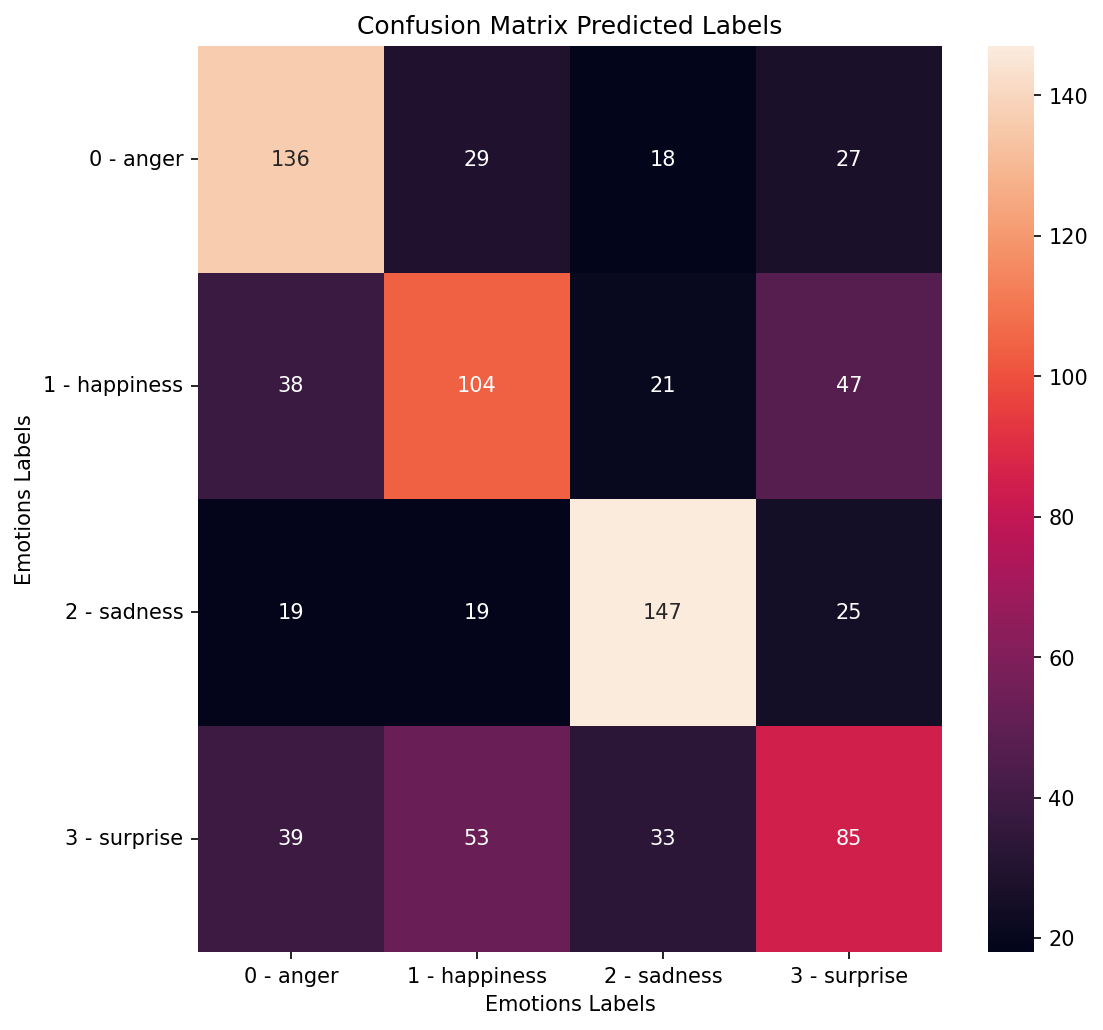

In [140]:
pca = PCA(n_components=num_component_elim)
data_pca_elim_ideal_comp = pca.fit_transform(data_scaled_elim)
plot_cm_predictions(
    Ridge(random_state=1),
    data_pca_elim_ideal_comp, labels
)

## 1.3.1.2 - One vs Rest Classifier

accuracy:  0.6583333333333333
f1 score macro:  0.6532799820146907
f1 score micro:  0.6583333333333333
precision score:  0.653627521006594
recall score:  0.6583333333333333
hamming_loss:  0.3416666666666667
matthews_corrcoef:  0.5459226652206823
zero_one_loss:  0.3416666666666667
               precision    recall  f1-score   support

    0 - anger       0.71      0.77      0.74       210
1 - happiness       0.61      0.60      0.60       210
  2 - sadness       0.68      0.78      0.73       210
 3 - surprise       0.61      0.49      0.54       210

     accuracy                           0.66       840
    macro avg       0.65      0.66      0.65       840
 weighted avg       0.65      0.66      0.65       840



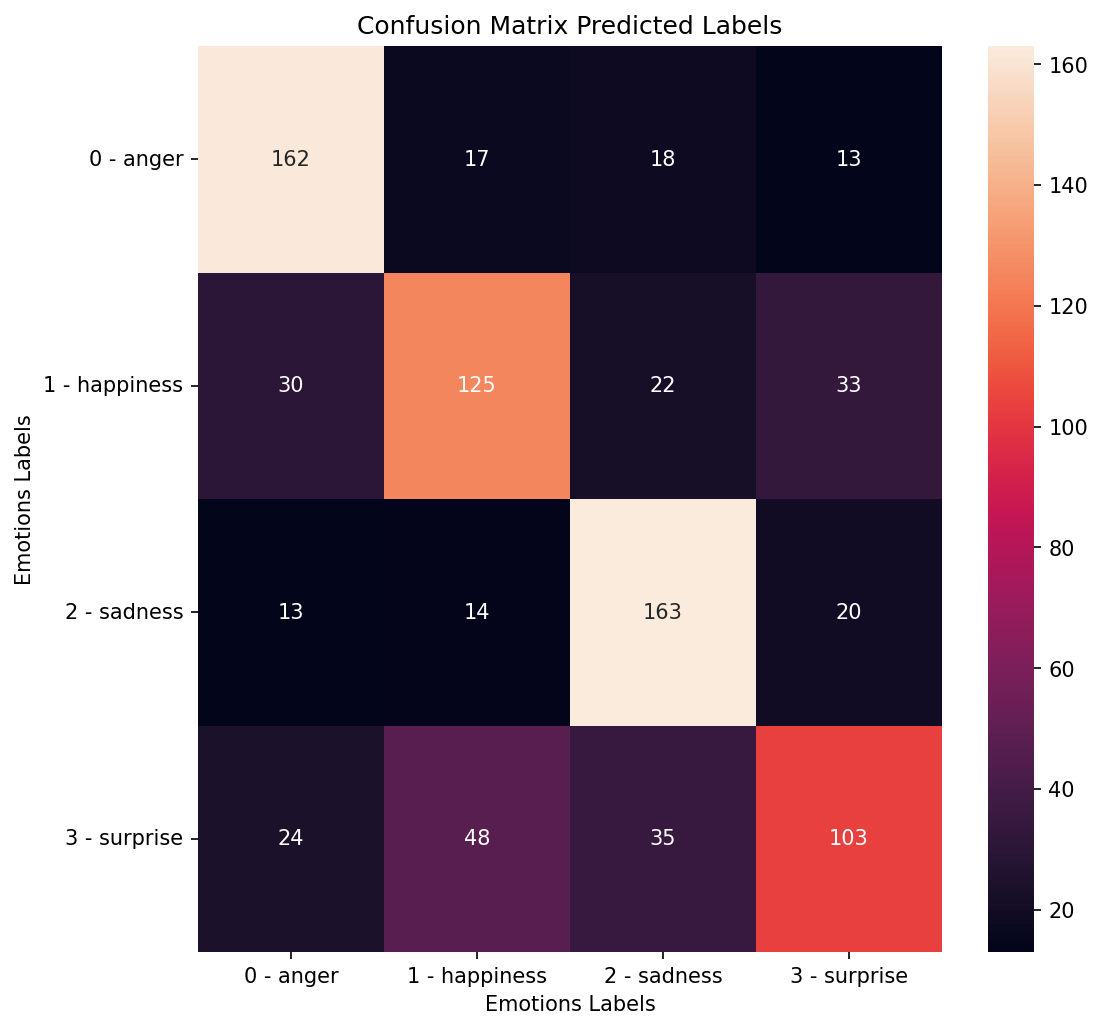

In [141]:
plot_cm_predictions(
    OneVsRestClassifier(Ridge(random_state=1)),
    data_elim_feats.values, labels
)

accuracy:  0.6202380952380953
f1 score macro:  0.6195480869931024
f1 score micro:  0.6202380952380953
precision score:  0.6195728564818828
recall score:  0.6202380952380953
hamming_loss:  0.37976190476190474
matthews_corrcoef:  0.49385894512196393
zero_one_loss:  0.37976190476190474
               precision    recall  f1-score   support

    0 - anger       0.69      0.70      0.69       210
1 - happiness       0.55      0.58      0.56       210
  2 - sadness       0.69      0.70      0.70       210
 3 - surprise       0.55      0.51      0.53       210

     accuracy                           0.62       840
    macro avg       0.62      0.62      0.62       840
 weighted avg       0.62      0.62      0.62       840



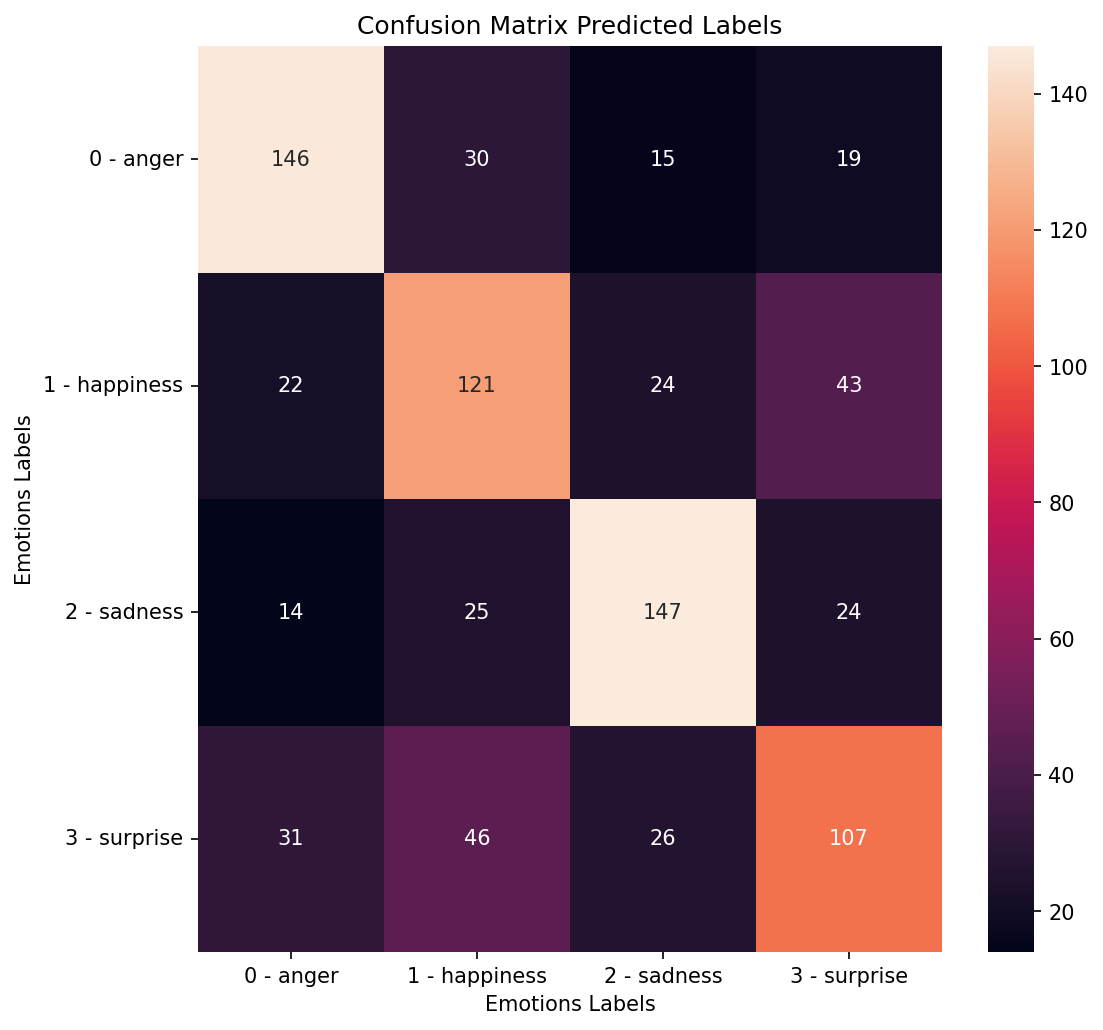

In [142]:
plot_cm_predictions(
    OneVsRestClassifier(Ridge(random_state=1)),
    df[df.columns[4:]].values, labels
)

## Valence and Arousal

In [143]:
display(HTML('<a href="https://www.researchgate.net/figure/Emotions-in-valence-arousal-space-13_fig3_329718637"><img src="https://www.researchgate.net/profile/Ananya-Bhattacharjee/publication/329718637/figure/fig3/AS:704946219532291@1545083684893/Emotions-in-valence-arousal-space-13.ppm" alt="Emotions in valence-arousal space [13]"/></a>'))

In [151]:
emotions = {
    0: 'anger',
    1: 'happiness',
    2: 'sadness',
    3: 'surprise'
}
emo_val = {
    'anger': 0,
    'disgust': 0,
    'fear': 0,
    'happiness': 1,
    'sadness': 0,
    'surprise': 1
}
emo_aro = {
    'anger': 1,
    'disgust': 1,
    'fear': 1,
    'happiness': 1,
    'sadness': 0,
    'surprise': 1
}
multi_pred = {
    (0, 0): 0,
    (0, 1): 1,
    (1, 1): 2
}
labels_val = [emo_val[emotions[e]] for e in labels]
labels_aro = [emo_aro[emotions[e]] for e in labels]
labels_val_aro = [multi_pred[(emo_val[emotions[e]], emo_aro[emotions[e]])] for e in labels]

## Classification for valence only

accuracy:  0.7583333333333333
f1 score macro:  0.7583302508110221
f1 score micro:  0.7583333333333333
precision score:  0.7583465142779393
recall score:  0.7583333333333333
hamming_loss:  0.24166666666666667
matthews_corrcoef:  0.5166798474431441
zero_one_loss:  0.2416666666666667
                  precision    recall  f1-score   support

 0 - Low Valence       0.76      0.75      0.76       420
1 - High Valence       0.76      0.76      0.76       420

        accuracy                           0.76       840
       macro avg       0.76      0.76      0.76       840
    weighted avg       0.76      0.76      0.76       840



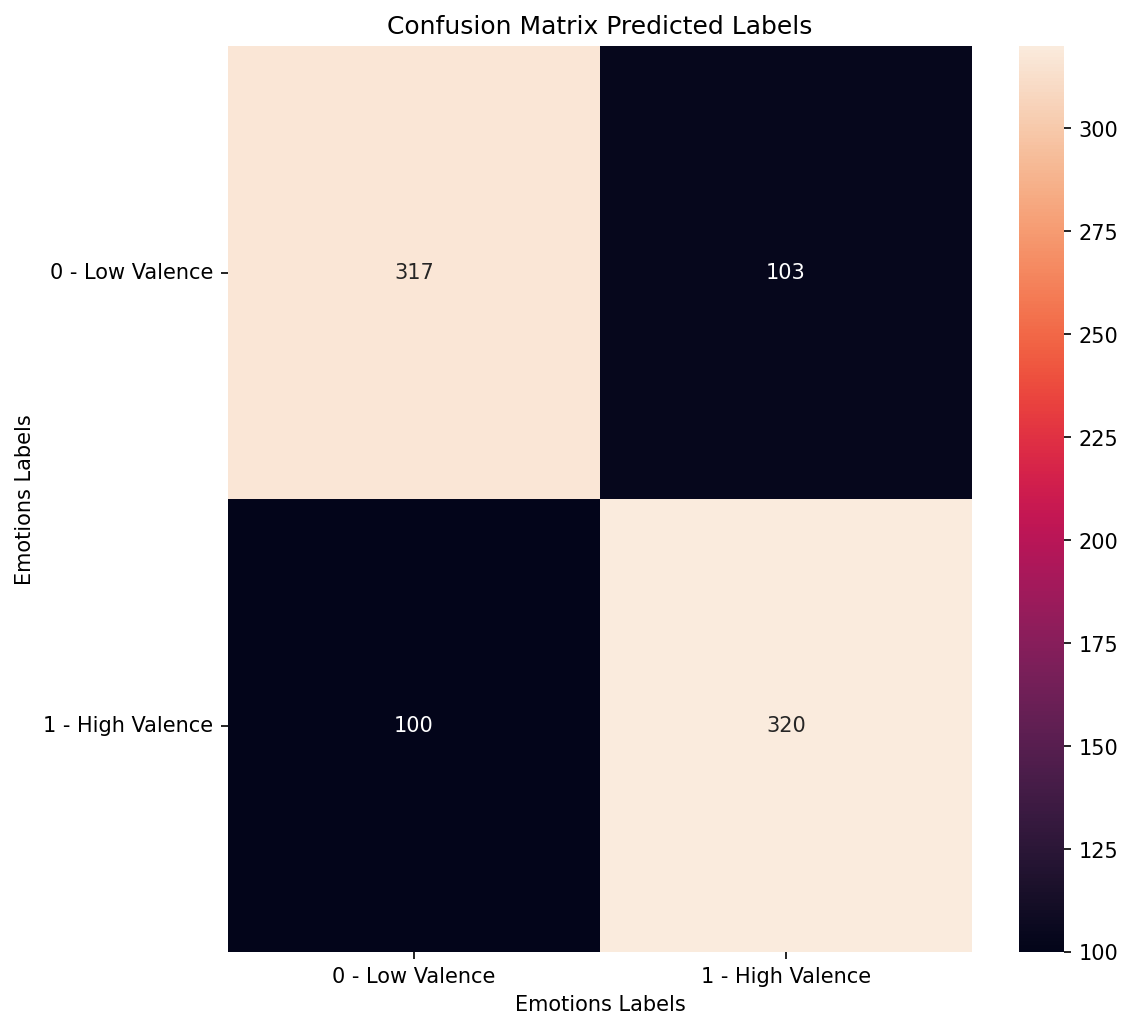

In [152]:
plot_cm_predictions(
    Ridge(random_state=1),
    data_elim_feats.values, labels_val, val=True
)

## Classification for arousal only

accuracy:  0.8559523809523809
f1 score macro:  0.7990474326352188
f1 score micro:  0.8559523809523808
precision score:  0.815268108890386
recall score:  0.7865079365079366
hamming_loss:  0.14404761904761904
matthews_corrcoef:  0.6010883972426815
zero_one_loss:  0.1440476190476191
                  precision    recall  f1-score   support

 0 - Low Arousal       0.74      0.65      0.69       210
1 - High Arousal       0.89      0.93      0.91       630

        accuracy                           0.86       840
       macro avg       0.82      0.79      0.80       840
    weighted avg       0.85      0.86      0.85       840



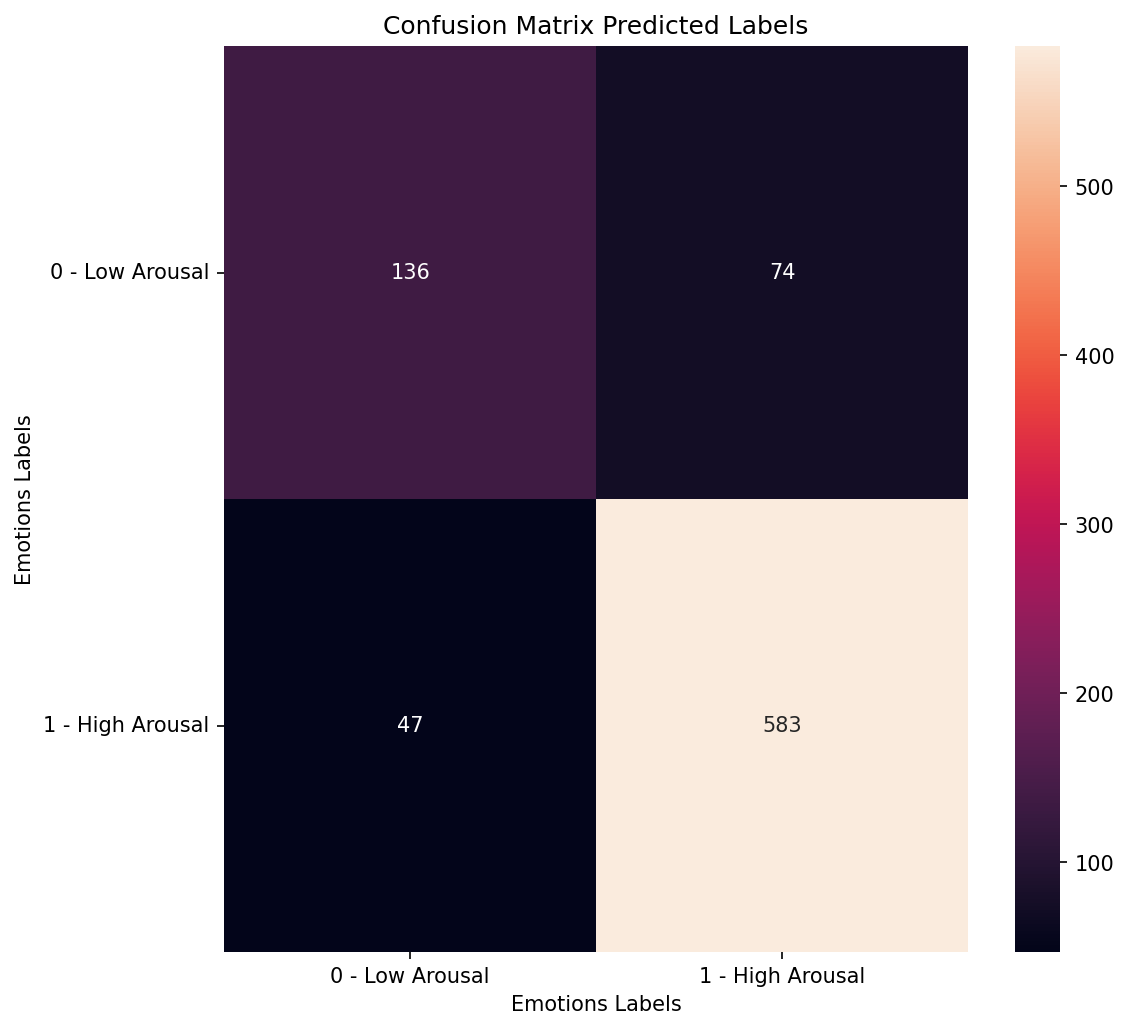

In [153]:
plot_cm_predictions(
    Ridge(random_state=1),
    data_elim_feats.values, labels_aro, aro=True
)

## Classification for valence and arousal

### For all features

accuracy:  0.7166666666666667
f1 score macro:  0.7063761830115336
f1 score micro:  0.7166666666666667
precision score:  0.7037582435581853
recall score:  0.7095238095238096
hamming_loss:  0.2833333333333333
matthews_corrcoef:  0.5494447211704493
zero_one_loss:  0.2833333333333333
                              precision    recall  f1-score   support

            (0, 0) - sadness       0.67      0.67      0.67       210
              (0, 1) - anger       0.68      0.72      0.70       210
(1, 1) - happiness, surprise       0.76      0.74      0.75       420

                    accuracy                           0.72       840
                   macro avg       0.70      0.71      0.71       840
                weighted avg       0.72      0.72      0.72       840



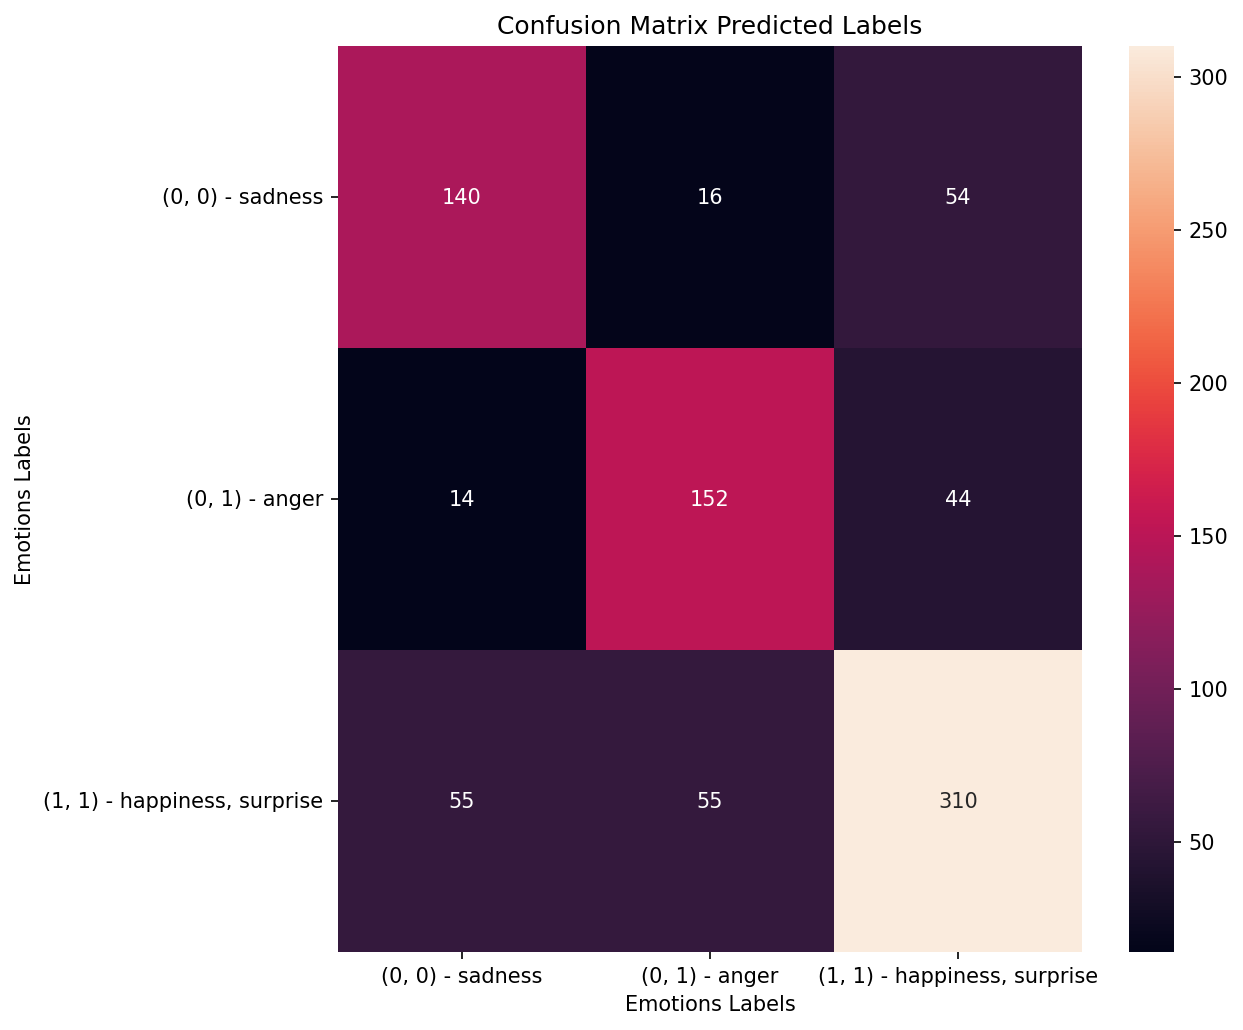

In [154]:
plot_cm_predictions(
    Ridge(random_state=1),
    df[df.columns[4:]].values, labels_val_aro, val=True, aro=True
)

### For the features after high correlation and backward propagation

accuracy:  0.7309523809523809
f1 score macro:  0.7157700214933184
f1 score micro:  0.7309523809523809
precision score:  0.7248148148148147
recall score:  0.7087301587301588
hamming_loss:  0.26904761904761904
matthews_corrcoef:  0.5642669489661346
zero_one_loss:  0.2690476190476191
                              precision    recall  f1-score   support

            (0, 0) - sadness       0.73      0.70      0.71       210
              (0, 1) - anger       0.70      0.63      0.67       210
(1, 1) - happiness, surprise       0.74      0.80      0.77       420

                    accuracy                           0.73       840
                   macro avg       0.72      0.71      0.72       840
                weighted avg       0.73      0.73      0.73       840



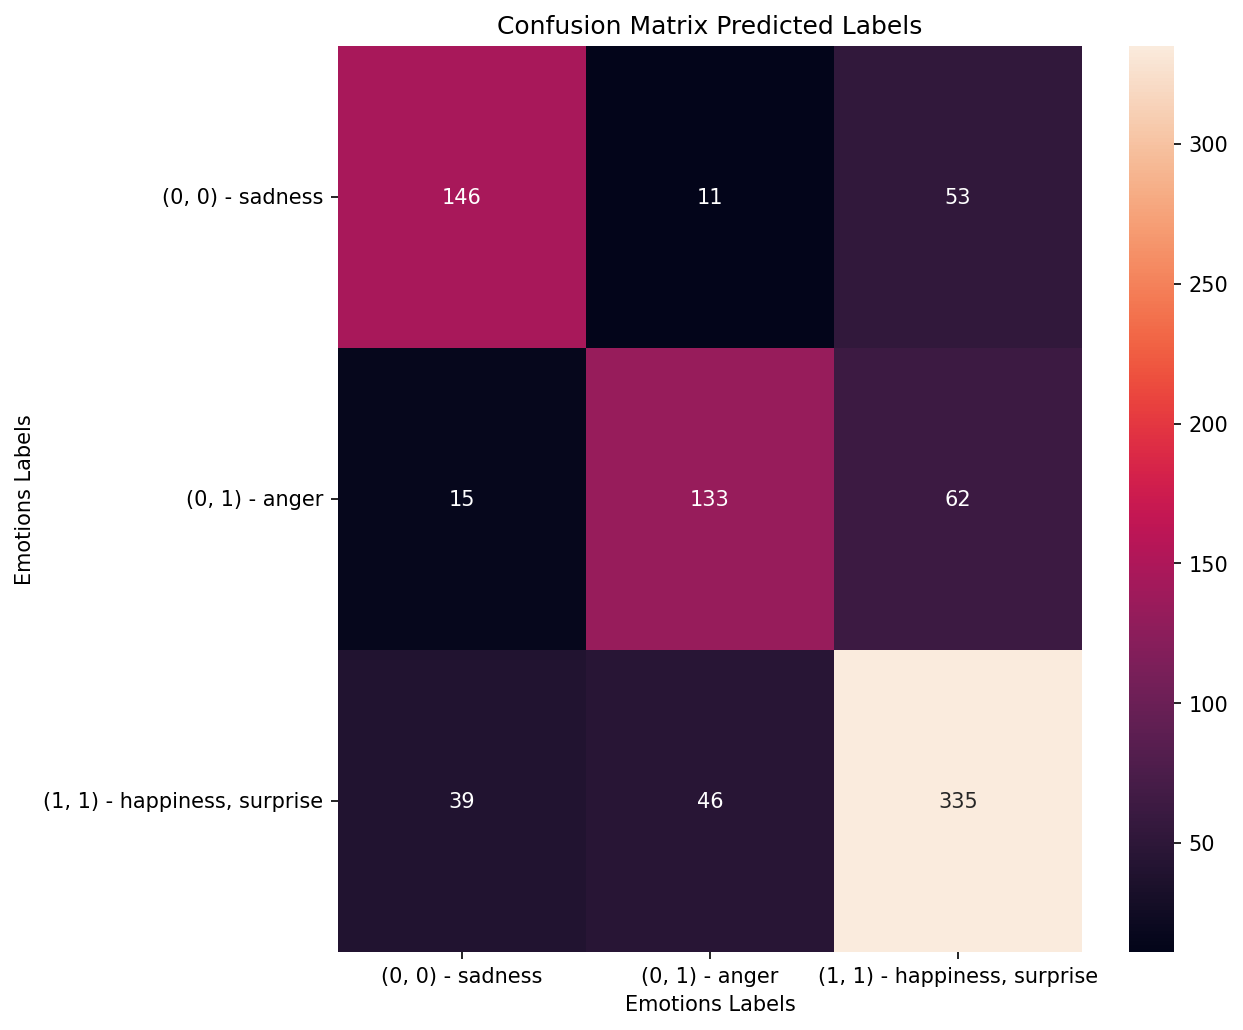

In [155]:
plot_cm_predictions(
    Ridge(random_state=1),
    data_elim_feats.values, labels_val_aro, val=True, aro=True
)

## Balanced Trees

C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\User

accuracy:  0.6654761904761904
f1 score macro:  0.6647737123813314
f1 score micro:  0.6654761904761904
precision score:  0.6570304645445
recall score:  0.688888888888889
hamming_loss:  0.3345238095238095
matthews_corrcoef:  0.4951030257926629
zero_one_loss:  0.33452380952380956
                              precision    recall  f1-score   support

            (0, 0) - sadness       0.63      0.74      0.68       210
              (0, 1) - anger       0.58      0.73      0.64       210
(1, 1) - happiness, surprise       0.77      0.60      0.67       420

                    accuracy                           0.67       840
                   macro avg       0.66      0.69      0.66       840
                weighted avg       0.68      0.67      0.67       840



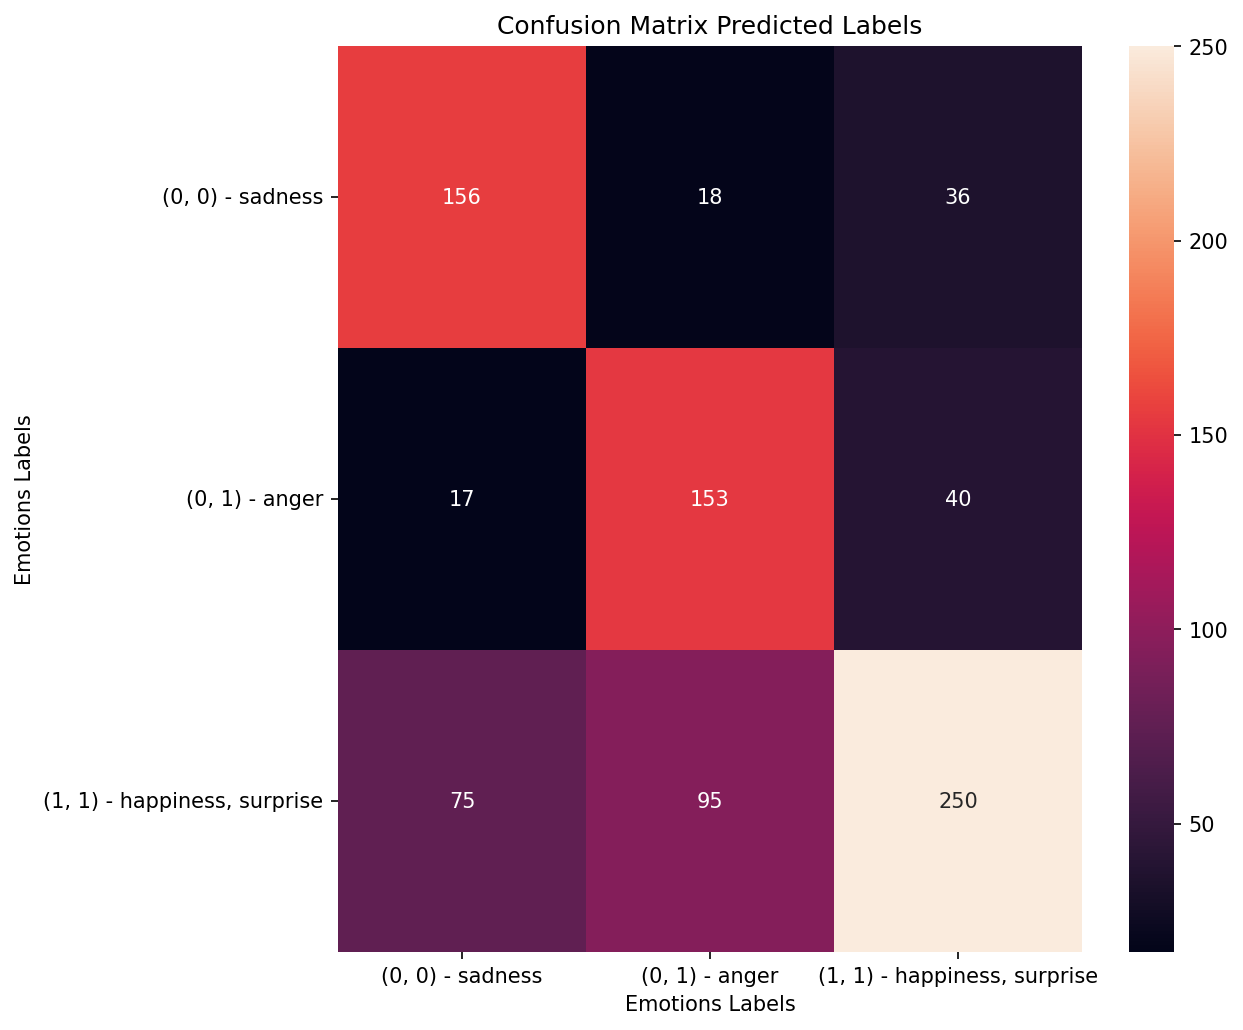

In [156]:
plot_cm_predictions(
    BalancedRandomForestClassifier(random_state=1, max_features=None),
    data_elim_feats.values, labels_val_aro, val=True, aro=True
)

In [157]:
plot_cm_predictions(
    BalancedBaggingClassifier(
        RandomForest(random_state=1, max_features=None), 100, random_state=1, n_jobs=8
    ),
    data_elim_feats.values, labels_val_aro, val=True, aro=True
)

KeyboardInterrupt: 

accuracy:  0.5880952380952381
f1 score macro:  0.5873188950433841
f1 score micro:  0.5880952380952381
precision score:  0.5831263296546161
recall score:  0.6341269841269841
hamming_loss:  0.4119047619047619
matthews_corrcoef:  0.3842563209193757
zero_one_loss:  0.4119047619047619
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.47      0.78      0.59       210
(0, 1) - anger, disgust, fear       0.74      0.50      0.60       630
 (1, 1) - happiness, surprise       0.54      0.62      0.57       420

                     accuracy                           0.59      1260
                    macro avg       0.58      0.63      0.59      1260
                 weighted avg       0.63      0.59      0.59      1260



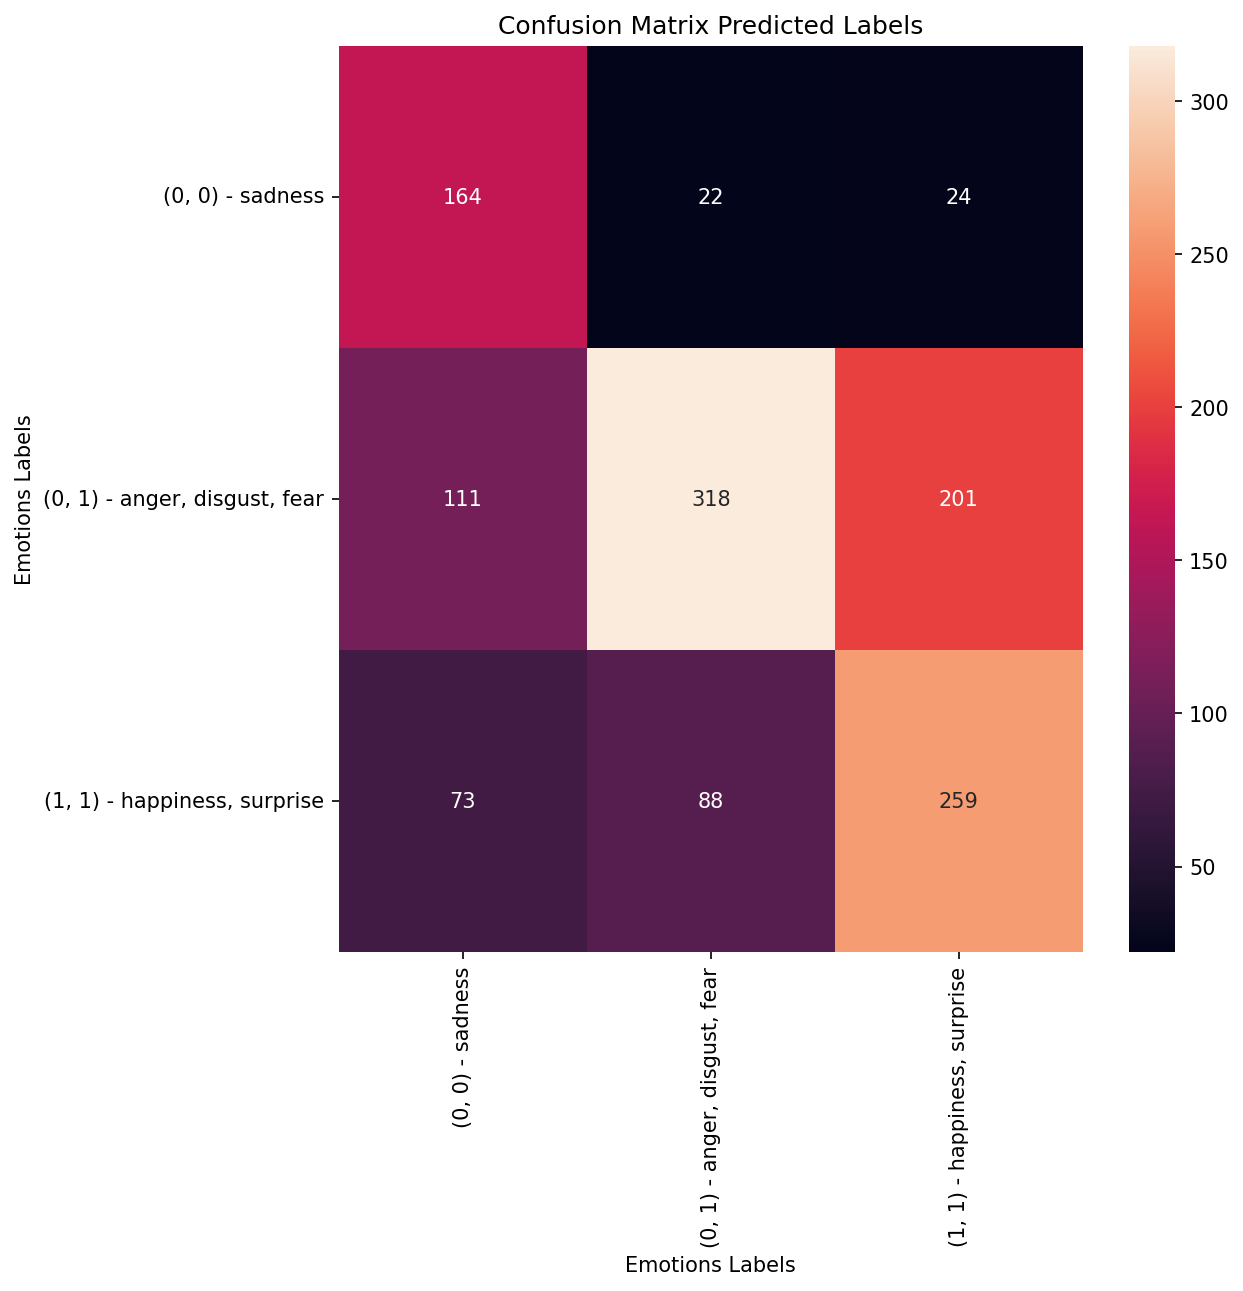

In [ ]:
plot_cm_predictions(
    EasyEnsembleClassifier(
        100, Ridge(random_state=1), random_state=1, n_jobs=8
    ),
    data_elim_feats.values, labels_val_aro, val=True, aro=True
)

accuracy:  0.5444444444444444
f1 score macro:  0.5457613850245439
f1 score micro:  0.5444444444444444
precision score:  0.5414023328916946
recall score:  0.5894179894179894
hamming_loss:  0.45555555555555555
matthews_corrcoef:  0.31651181841305137
zero_one_loss:  0.4555555555555556
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.45      0.70      0.55       210
(0, 1) - anger, disgust, fear       0.67      0.43      0.53       630
 (1, 1) - happiness, surprise       0.51      0.63      0.56       420

                     accuracy                           0.54      1260
                    macro avg       0.54      0.59      0.55      1260
                 weighted avg       0.58      0.54      0.54      1260



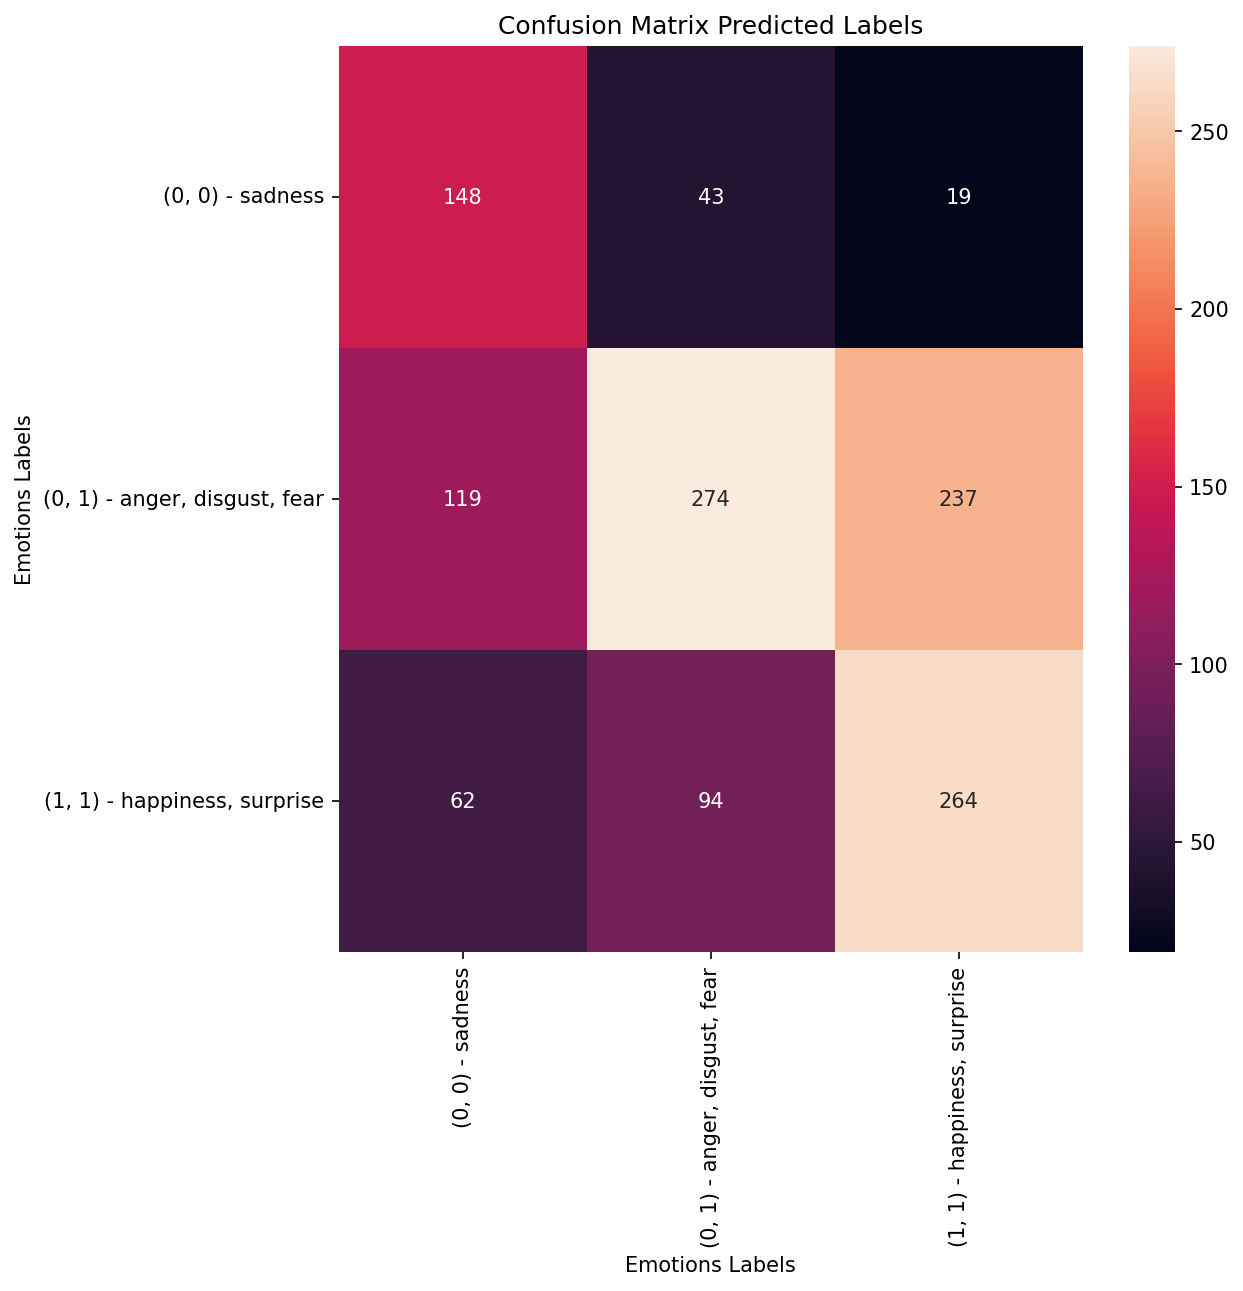

In [ ]:
plot_cm_predictions(
    RUSBoostClassifier(
        RandomForest(random_state=1, max_features=None, n_jobs=8), n_estimators=100, random_state=1
    ),
    data_elim_feats.values, labels_val_aro, val=True, aro=True
)

## Simple Deep Learning

### Model

In [ ]:
def build_model_0(input_shape=(12, 1)):
    model = Sequential()
    model.add(Conv1D(64, 5, input_shape=input_shape))
    model.add(Activation('relu'))#2nd hidden layer
    model.add(Conv1D(64, 5, padding="same"))
    model.add(Activation('relu'))#3rd hidden layer
    model.add(Conv1D(64, 5, padding="same"))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))#Add fully connected layer.
    model.add(GlobalAveragePooling1D())
    model.add(Flatten())
    model.add(Dense(3))
    model.add(Activation('softmax'))
    # Compile Model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
build_model_0(input_shape=(data_elim_feats.shape[1], 1)).summary()

2022-05-19 20:29:16.913716: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            384       
                                                                 
 activation (Activation)     (None, 20, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 64)            20544     
                                                                 
 activation_1 (Activation)   (None, 20, 64)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 20, 64)            20544     
                                                                 
 activation_2 (Activation)   (None, 20, 64)            0         
                                                                 
 dropout (Dropout)           (None, 20, 64)            0

In [ ]:
def build_model_1(input_shape=(12, 1)):
    model = Sequential()
    model.add(Conv1D(256, 5,padding='same', input_shape=input_shape)) #1
    model.add(Activation('relu'))
    model.add(Conv1D(128, 5,padding='same')) #2
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Conv1D(128, 5,padding='same')) #3
    model.add(Activation('relu'))
    model.add(Conv1D(128, 5,padding='same')) #6
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(3)) #7
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
build_model_1(input_shape=(data_elim_feats.shape[1], 1)).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 24, 256)           1536      
                                                                 
 activation_4 (Activation)   (None, 24, 256)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 24, 128)           163968    
                                                                 
 activation_5 (Activation)   (None, 24, 128)           0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 128)           0         
 )                                                               
                                                      

### Compile and fit model

### Accuracy metric to evaluate performance, using adam optimizer, and categorical crossentropy as the loss function

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
estimator = KerasRegressor(build_fn=build_model_0, input_shape=(data_elim_feats.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])

/var/folders/p6/n3vpmbmn2s15fhn83qmld1800000gn/T/ipykernel_1197/858656607.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=build_model_0, input_shape=(data_elim_feats.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])


accuracy:  0.5087301587301587
f1 score macro:  0.3342038809772057
f1 score micro:  0.5087301587301587
precision score:  0.4954322743796427
recall score:  0.3724867724867725
hamming_loss:  0.49126984126984125
matthews_corrcoef:  0.091977075745735
zero_one_loss:  0.4912698412698413
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.50      0.09      0.15       210
(0, 1) - anger, disgust, fear       0.51      0.90      0.65       630
 (1, 1) - happiness, surprise       0.47      0.13      0.20       420

                     accuracy                           0.51      1260
                    macro avg       0.50      0.37      0.33      1260
                 weighted avg       0.50      0.51      0.42      1260



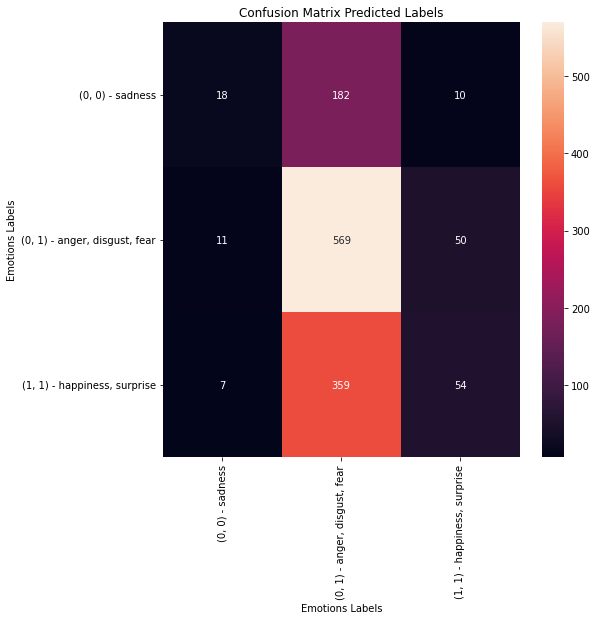

In [ ]:
one_hot_encoding = {
    0: [1, 0, 0],
    1: [0, 1, 0],
    2: [0, 0, 1],
}
one_hot_labels_val_aro = [one_hot_encoding[i] for i in labels_val_aro]

plot_cm_predictions(estimator, data_elim_feats, labels_val_aro, val=True, aro=True,
    one_hot_encoding=pd.DataFrame(one_hot_labels_val_aro))

/var/folders/p6/n3vpmbmn2s15fhn83qmld1800000gn/T/ipykernel_1197/42186902.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=build_model_1, input_shape=(data_elim_feats.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])


accuracy:  0.4928571428571429
f1 score macro:  0.34940645522629127
f1 score micro:  0.4928571428571429
precision score:  0.41438148399614255
recall score:  0.3812169312169312
hamming_loss:  0.5071428571428571
matthews_corrcoef:  0.08340195689849099
zero_one_loss:  0.5071428571428571
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.38      0.19      0.25       210
(0, 1) - anger, disgust, fear       0.52      0.86      0.65       630
 (1, 1) - happiness, surprise       0.35      0.09      0.15       420

                     accuracy                           0.49      1260
                    macro avg       0.41      0.38      0.35      1260
                 weighted avg       0.44      0.49      0.42      1260



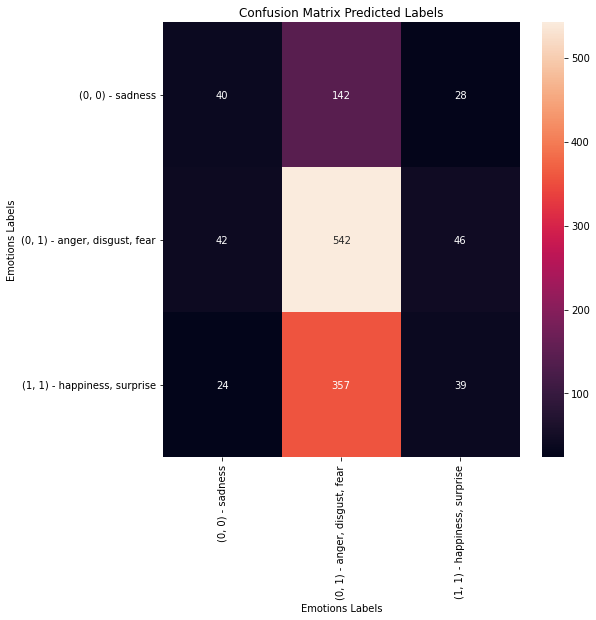

In [ ]:
estimator = KerasRegressor(build_fn=build_model_1, input_shape=(data_elim_feats.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])

plot_cm_predictions(estimator, data_elim_feats, labels_val_aro, val=True, aro=True,
    one_hot_encoding=pd.DataFrame(one_hot_labels_val_aro))

## For all initial 194 features

/var/folders/p6/n3vpmbmn2s15fhn83qmld1800000gn/T/ipykernel_1197/4255217135.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=build_model_0, input_shape=(data.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])


accuracy:  0.5023809523809524
f1 score macro:  0.4114487508046871
f1 score micro:  0.5023809523809524
precision score:  0.46771421771421773
recall score:  0.4235449735449735
hamming_loss:  0.4976190476190476
matthews_corrcoef:  0.12478324762322404
zero_one_loss:  0.4976190476190476
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.47      0.32      0.38       210
(0, 1) - anger, disgust, fear       0.52      0.80      0.63       630
 (1, 1) - happiness, surprise       0.41      0.15      0.22       420

                     accuracy                           0.50      1260
                    macro avg       0.47      0.42      0.41      1260
                 weighted avg       0.48      0.50      0.45      1260



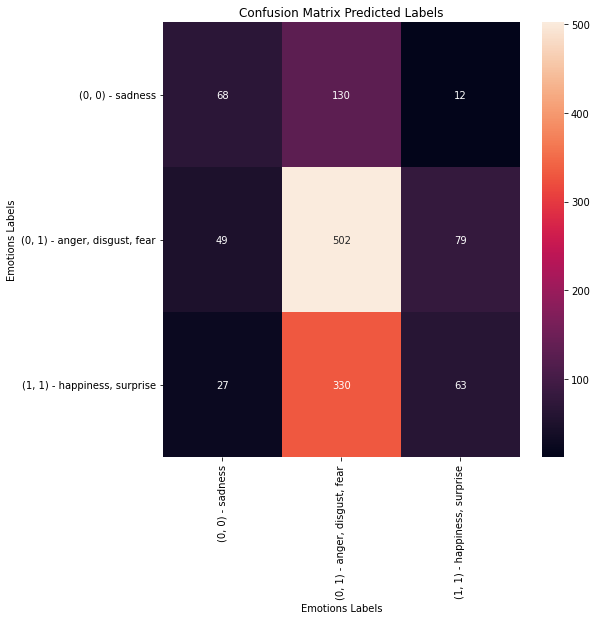

In [ ]:
estimator = KerasRegressor(build_fn=build_model_0, input_shape=(data.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])

plot_cm_predictions(estimator, data, labels_val_aro, val=True, aro=True,
    one_hot_encoding=pd.DataFrame(one_hot_labels_val_aro))

/var/folders/p6/n3vpmbmn2s15fhn83qmld1800000gn/T/ipykernel_1197/1634601177.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=build_model_1, input_shape=(data.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])


accuracy:  0.48095238095238096
f1 score macro:  0.3597213915546839
f1 score micro:  0.48095238095238096
precision score:  0.40626549116288646
recall score:  0.3992063492063492
hamming_loss:  0.5190476190476191
matthews_corrcoef:  0.08339805958429153
zero_one_loss:  0.519047619047619
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.38      0.32      0.35       210
(0, 1) - anger, disgust, fear       0.51      0.81      0.63       630
 (1, 1) - happiness, surprise       0.32      0.06      0.10       420

                     accuracy                           0.48      1260
                    macro avg       0.41      0.40      0.36      1260
                 weighted avg       0.43      0.48      0.41      1260



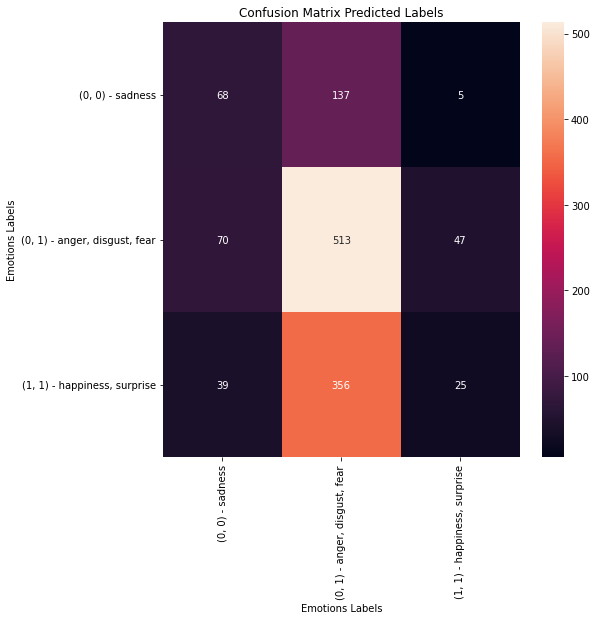

In [ ]:
estimator = KerasRegressor(build_fn=build_model_1, input_shape=(data.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])

plot_cm_predictions(estimator, data, labels_val_aro, val=True, aro=True,
    one_hot_encoding=pd.DataFrame(one_hot_labels_val_aro))